In [1]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import sqlite3
import numpy as np

NUMBER_OF_LEVELS = 3

def get_all_models_keys():
    conn = sqlite3.connect('./data/exploration.db')
    cur = conn.cursor()
    
    cur.execute('SELECT difficulty_train, model_id, truth FROM truth')
    keys = cur.fetchall()
    conn.close()
    return keys

def reconstruct_probs(difficult_train, model_id):
    conn = sqlite3.connect('./data/exploration.db')
    cur = conn.cursor()
    
    output = []
    for i in range(NUMBER_OF_LEVELS):
        values = (difficult_train, model_id, i,)
        cur.execute('SELECT win_prob, draw_prob, loss_prob FROM probabilities WHERE difficulty_train=? AND model_id=? AND difficulty_play=?', values)
        output.append(cur.fetchall())
    output_reshaped = []
    for i in range(3):
        tmp = []
        for j in range(NUMBER_OF_LEVELS):
            tmp.append(output[j][0][i])
        output_reshaped.append(tmp)
    conn.close()
    return output_reshaped

def reconstruct_mu_dynamics(difficult_train, model_id, baseline=False):
    conn = sqlite3.connect('./data/trueskill_dynamics.db')
    cur = conn.cursor()
    
    if baseline:
        cur.execute('SELECT * FROM dynamics_baseline WHERE difficulty_train=? AND model_id=? ORDER BY idx', (difficult_train, model_id,))
    else:
        cur.execute('SELECT * FROM dynamics WHERE difficulty_train=? AND model_id=? ORDER BY idx', (difficult_train, model_id,))
    data = cur.fetchall()
    plot_list = np.zeros((4,len(data)))
    opponents = []
    for i in range(NUMBER_OF_LEVELS + 1):
        for j in range(len(data)):
            plot_list[i][j] = (data[j][i+4])
    for j in range(len(data)):
        opponents.append(data[j][8])
    
    conn.close()
    return plot_list, opponents


        
def plot_(title, data, opps, pl_base, opp_base, probs, save_plots=False):
    %matplotlib inline
    plt.rcParams["figure.figsize"] = (15, 7) # (w, h)
    
    ax1 = plt.subplot2grid((2, 10), (0, 0), colspan=7)
    axx = plt.subplot2grid((2, 10), (1, 0), colspan=7)
    ax2 = plt.subplot2grid((2, 10), (0, 7), rowspan=2)
    ax3 = plt.subplot2grid((2, 10), (0, 8), rowspan=2)
    ax4 = plt.subplot2grid((2, 10), (0, 9), rowspan=2)
    
    easy_opp_indexes = []
    easy_opp_values = []
    medium_opp_indexes = []
    medium_opp_values = []
    hard_opp_indexes = []
    hard_opp_values = []
    
    for i in range(len(opps)-1):
        if opps[i] == 0:
            easy_opp_indexes.append(i+1)
            easy_opp_values.append(data[0][i+1])
        elif opps[i] == 1:
            medium_opp_indexes.append(i+1)
            medium_opp_values.append(data[1][i+1])
        elif opps[i] == 2:
            hard_opp_indexes.append(i+1)
            hard_opp_values.append(data[2][i+1])
        
    
    ax1.set_title('Our approach ' + title)
    a1 = ax1.plot(data[0])
    a2 = ax1.plot(data[1])
    a3 = ax1.plot(data[2])
    a4 = ax1.plot(data[3])
    ax1.scatter(easy_opp_indexes, easy_opp_values, c='C0')
    ax1.scatter(medium_opp_indexes, medium_opp_values, c='C1')
    ax1.scatter(hard_opp_indexes, hard_opp_values, c='C2')
    
    #l = Line2D([0],[0], marker='o', markerfacecolor='none', markeredgecolor='b', markersize=10)
    colors = ['C0','C1','C2']
    l = Line2D([0],[0], linestyle='None', marker='o', fillstyle='none', markeredgecolor='k', markersize=10)
    
    #a5 = ax1.scatter(range(1, len(opps)+1),opps, c='C6')
    ax1.legend((a1[0], a2[0], a3[0], a4[0], l), ('Easy', 'Medium', 'Hard', 'Player', 'Chosen\nlevel'), bbox_to_anchor=(-0.05, 0.2))
    
    easy_opp_indexes = []
    easy_opp_values = []
    medium_opp_indexes = []
    medium_opp_values = []
    hard_opp_indexes = []
    hard_opp_values = []
    
    for i in range(len(opp_base) -1):
        if opp_base[i] == 0:
            easy_opp_indexes.append(i+1)
            easy_opp_values.append(pl_base[0][i+1])
        elif opp_base[i] == 1:
            medium_opp_indexes.append(i+1)
            medium_opp_values.append(pl_base[1][i+1])
        elif opp_base[i] == 2:
            hard_opp_indexes.append(i+1)
            hard_opp_values.append(pl_base[2][i+1])
    
    
    
    
    axx.set_title('Baseline ' + title)
    axx.plot(pl_base[0])
    axx.plot(pl_base[1])
    axx.plot(pl_base[2])
    axx.plot(pl_base[3])
    #axx.scatter(range(1, len(opp_base)+1),opp_base, c='C6')
    axx.scatter(easy_opp_indexes, easy_opp_values, c='C0')
    axx.scatter(medium_opp_indexes, medium_opp_values, c='C1')
    axx.scatter(hard_opp_indexes, hard_opp_values, c='C2')
    
    ax2.set_title('Win prob')
    ax3.set_title('Draw prob')
    ax4.set_title('Loss prob')
    
    colors = ['C0','C1','C2']
    x = (0.9,1,1.1)
    lim=(-0.05,1.05)
    ax2.set_ylim(lim)
    ax3.set_ylim(lim)
    ax4.set_ylim(lim)
    ax2.yaxis.set_visible(False)
    ax3.yaxis.set_visible(False)
    ax4.yaxis.tick_right()
    ax2.bar(x, probs[0], width=0.08, color=colors)
    ax3.bar(x, probs[1], width=0.08, color=colors)
    ax4.bar(x, probs[2], width=0.08, color=colors)

    
    
    if save_plots:
        path = './img/cumulative_plots/with_baseline_bar/colored_choice_2/'
        plt.gcf().savefig(path + title + '.png', bbox_inches='tight')
    
    plt.show()
    
def plot_decision(title, data, data_base, truth, save_plots=False):
    %matplotlib inline
    plt.rcParams["figure.figsize"] = (15, 4) # (w, h)
    l = len(data)
    truth_p = []
    for i in range(l):
        truth_p.append(truth)

    a1 = plt.plot(range(l), data)
    a2 = plt.plot(range(l), data_base)
    a3 = plt.scatter(range(l), truth_p, color='C2')
    
    plt.gcf().legend((a1[0], a2[0], a3,), ('Our', 'Base', 'Truth'))
    plt.title(title)
    plt.ylim((-0.05,2.05))
    
    if save_plots:
        path = './img/cumulative_plots/convergency/'
        plt.gcf().savefig(path + title + '.png', bbox_inches='tight')
        
    plt.show()
    
def plot_truth_rate(title, data, baseline, save_plots=False, width=0.4):
    %matplotlib inline
    plt.rcParams["figure.figsize"] = (15, 7) # (w, h)
    x = range(len(data))
    x_baseline = [i+width for i in x]
    plt.bar(x, data, width=width)
    plt.bar(x_baseline, baseline, width=width)
    plt.ylim((-0.05,1.05))
    plt.show()

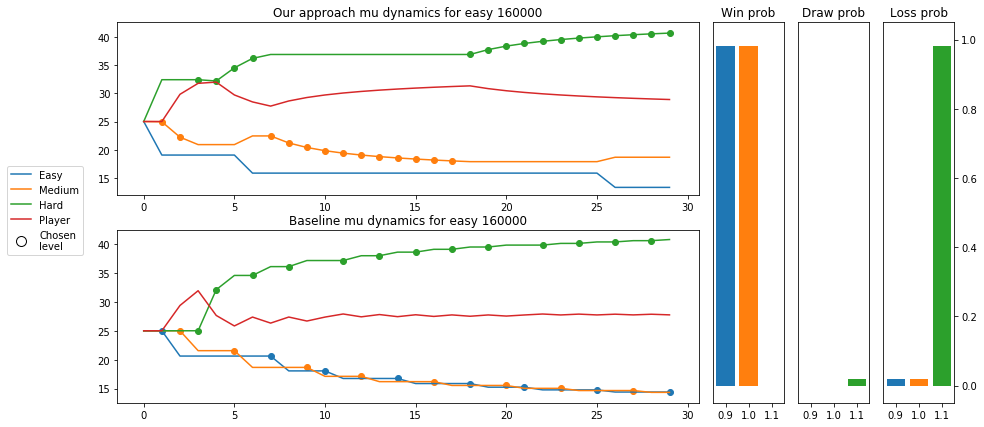

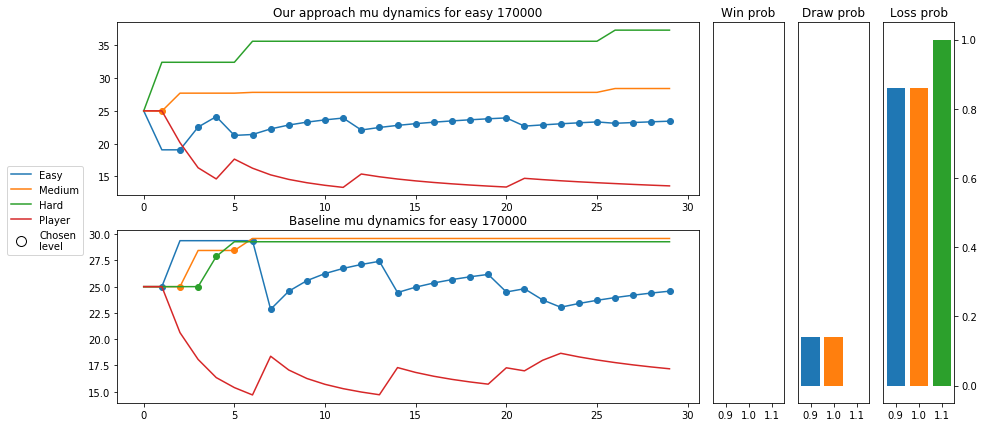

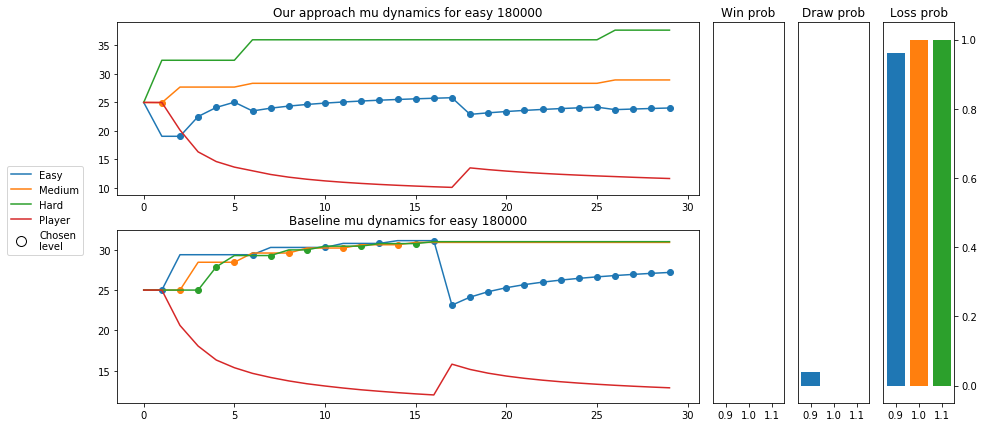

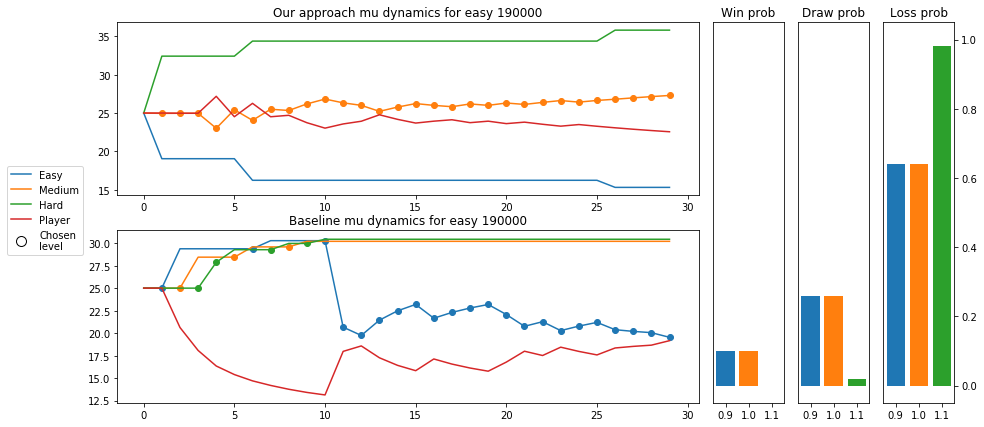

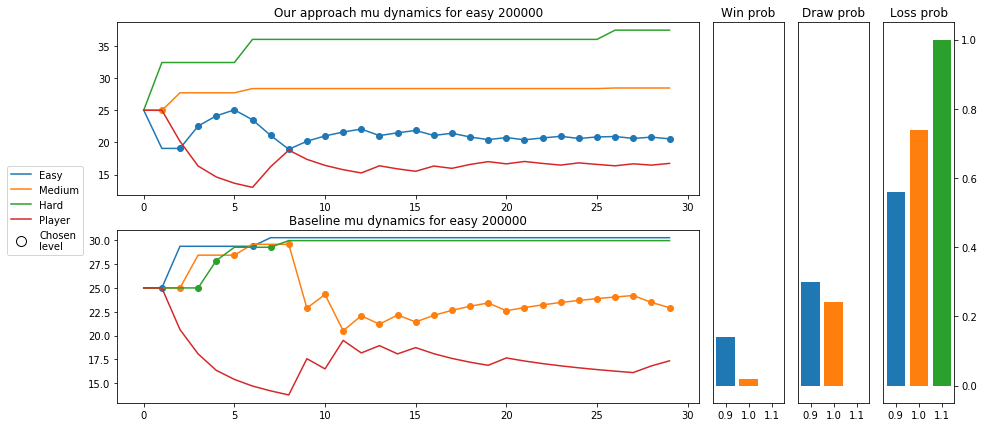

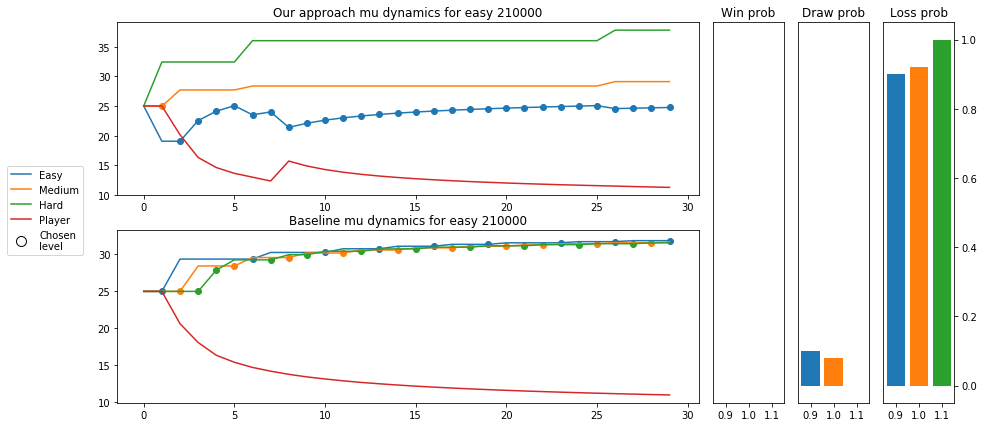

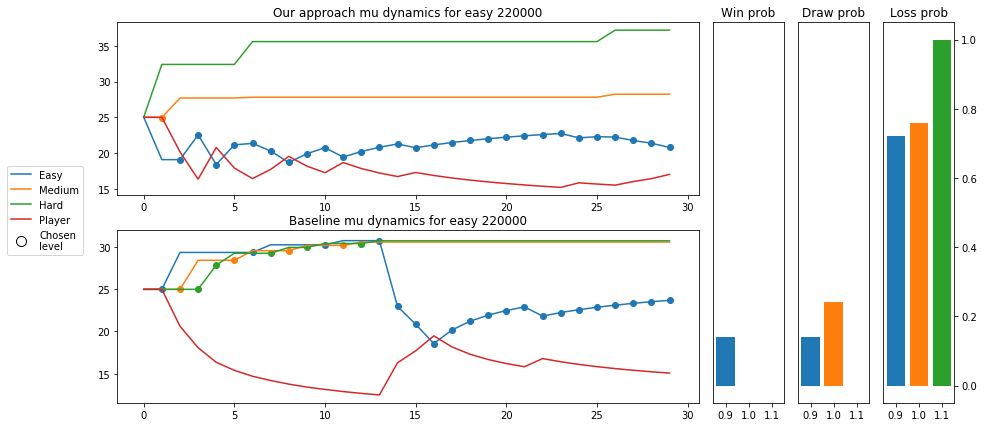

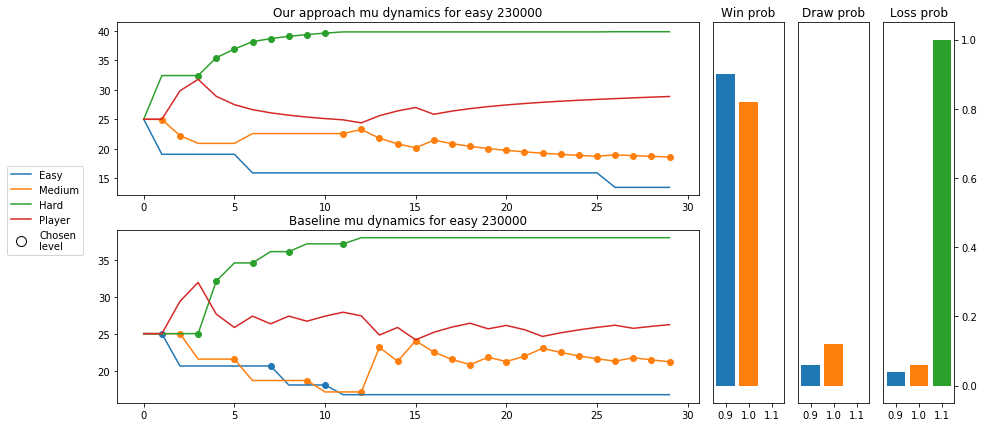

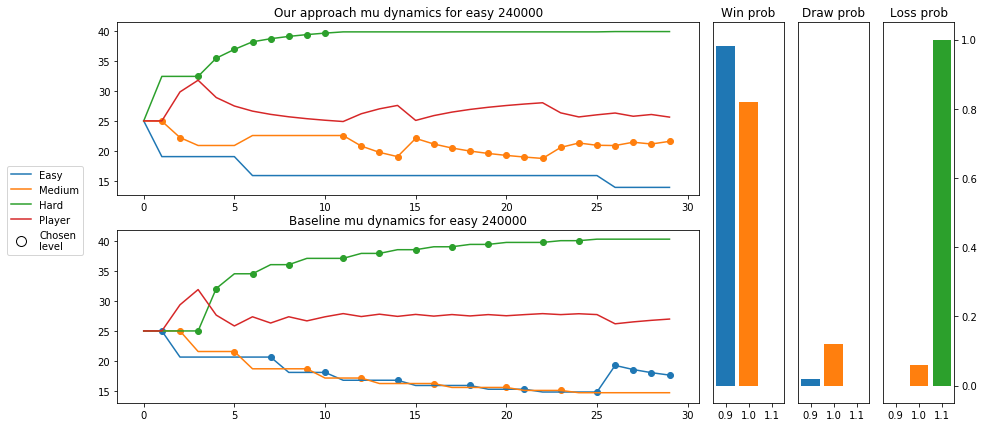

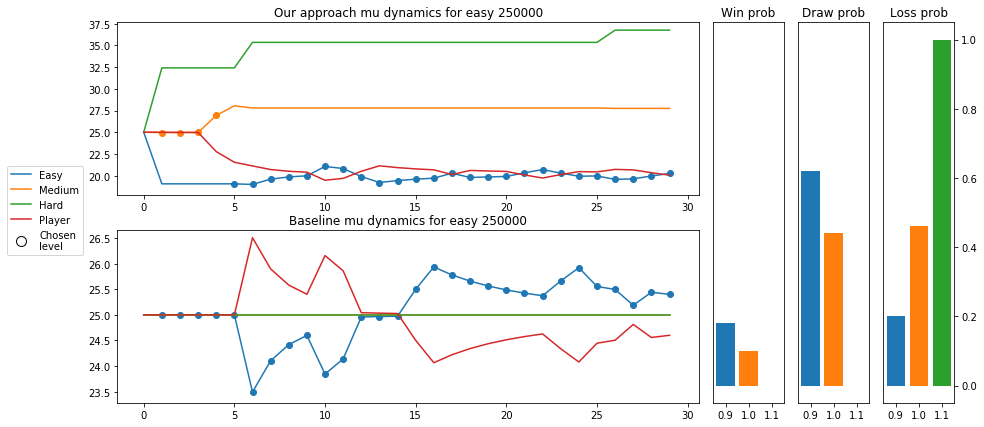

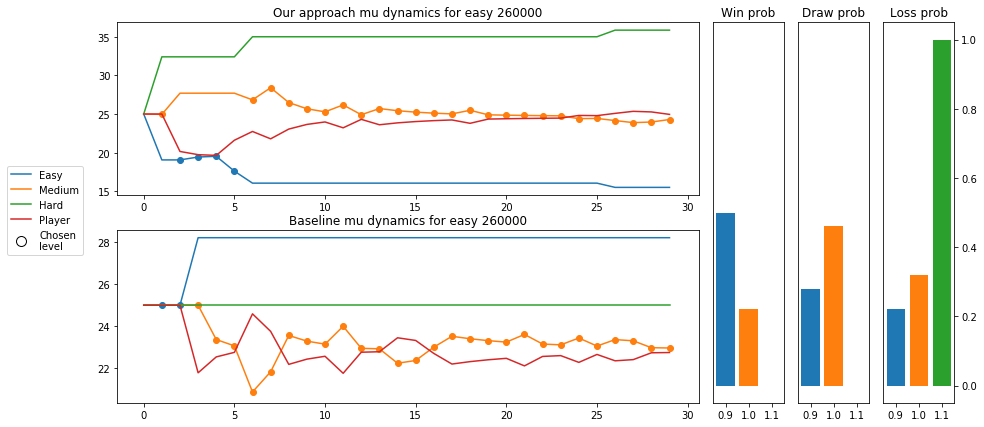

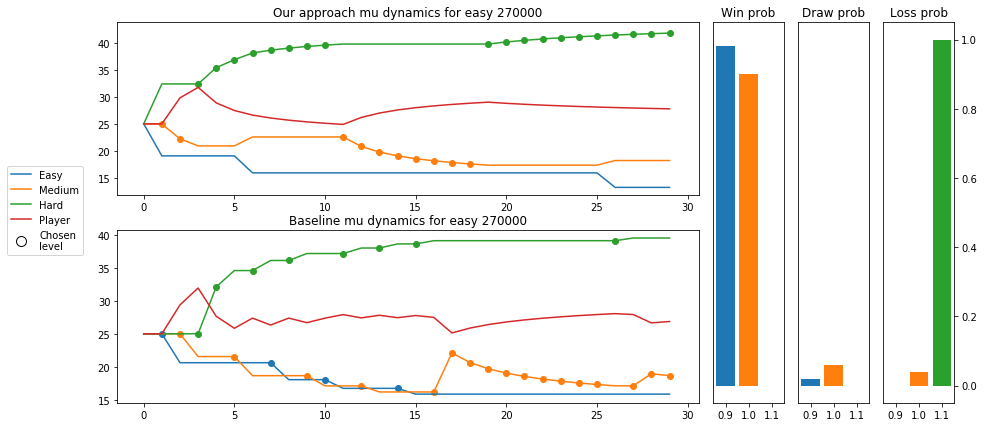

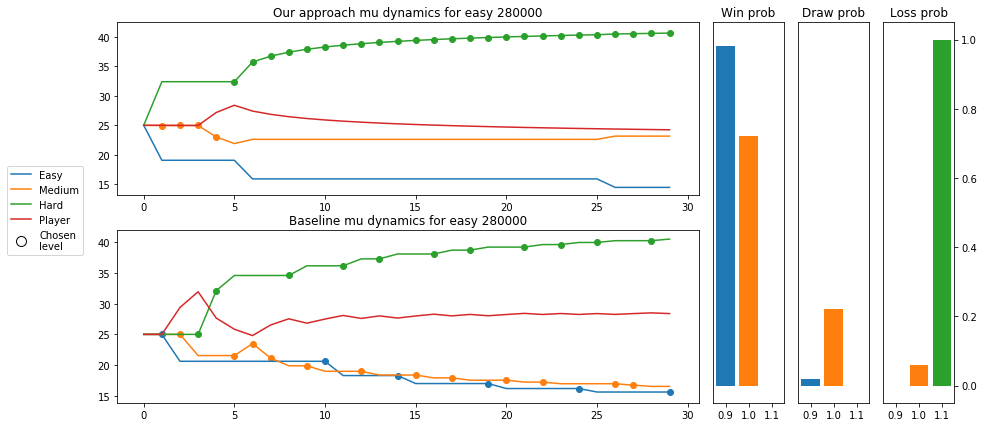

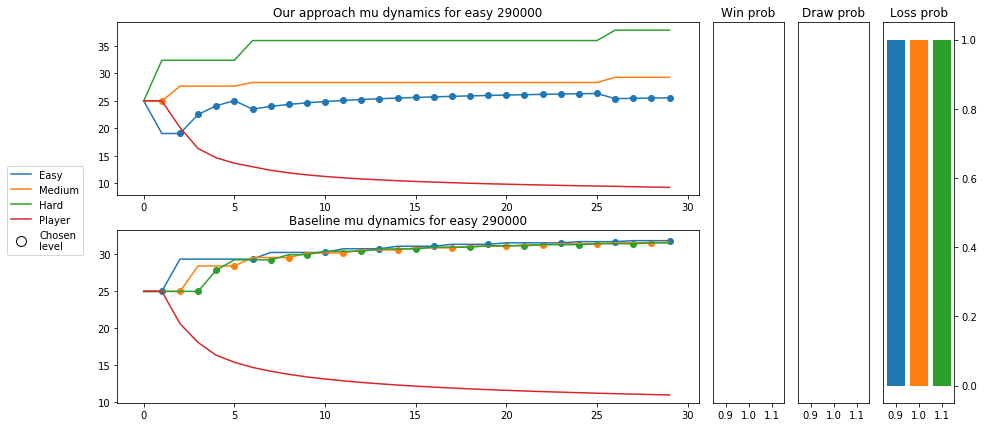

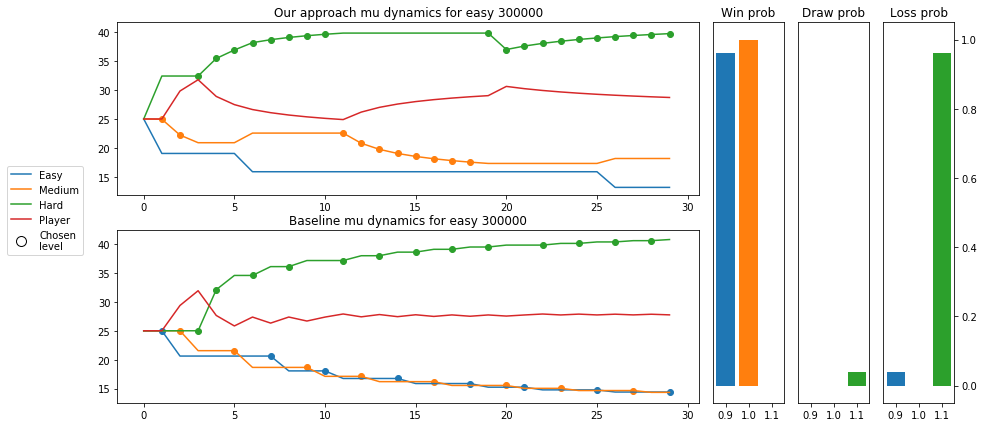

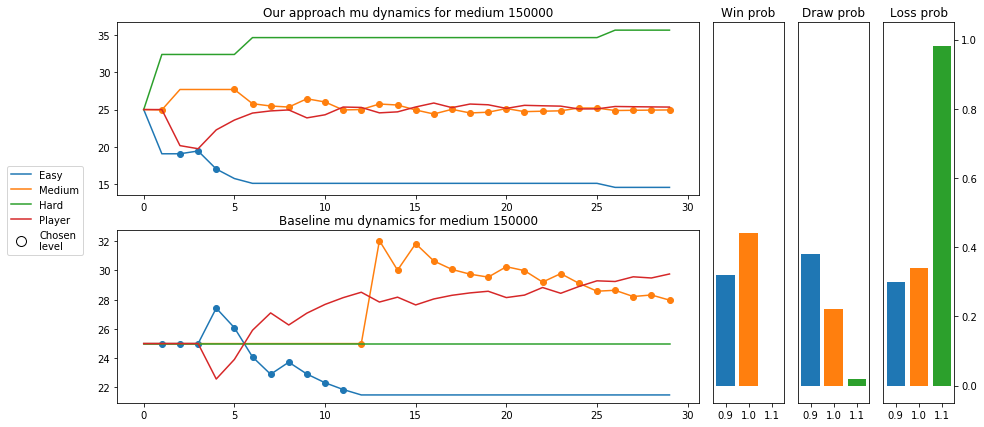

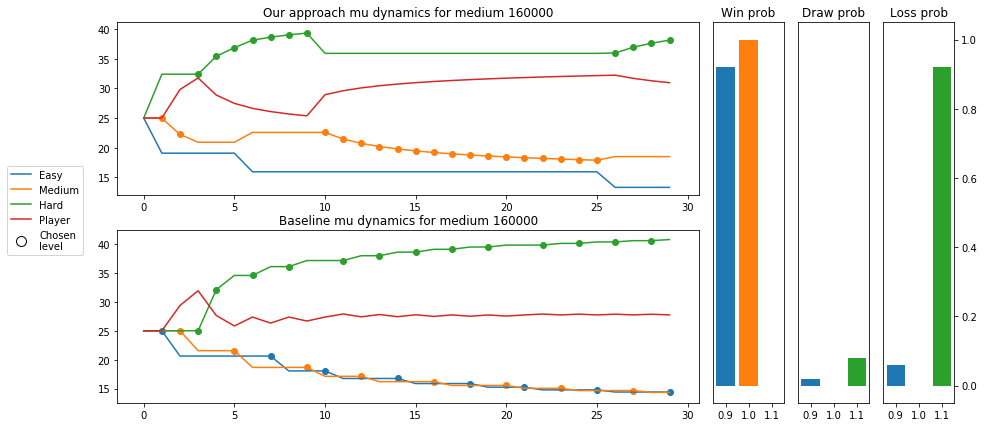

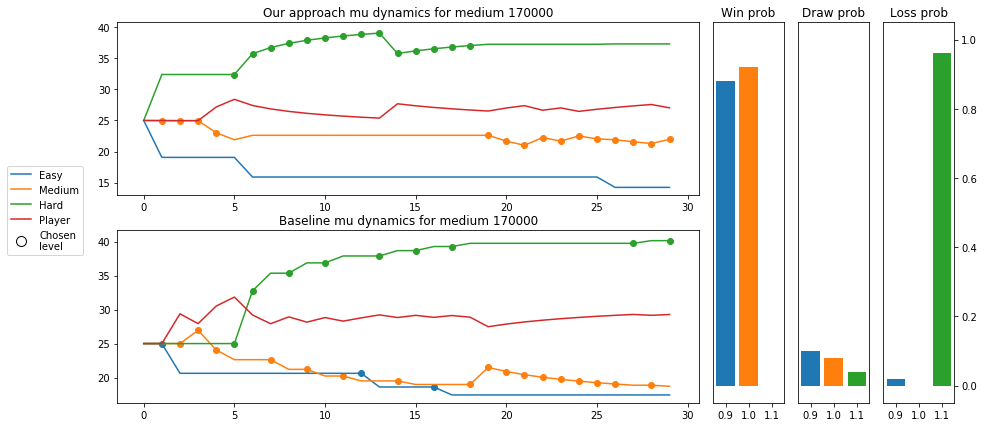

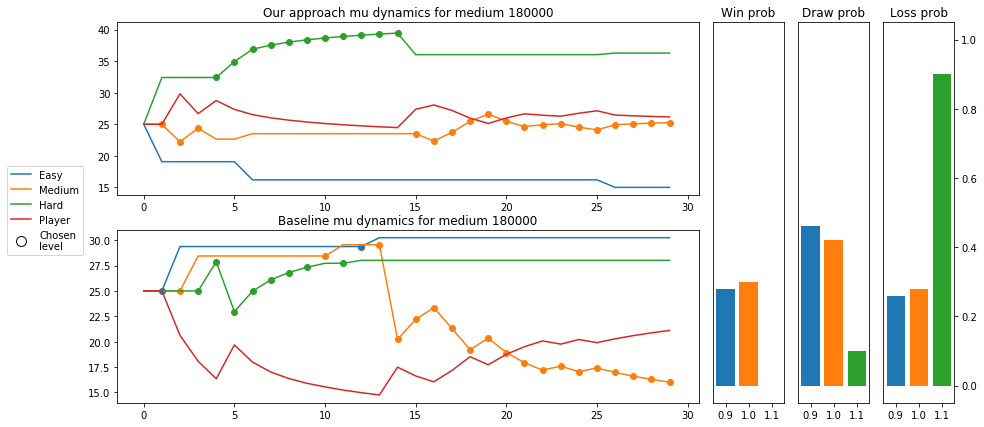

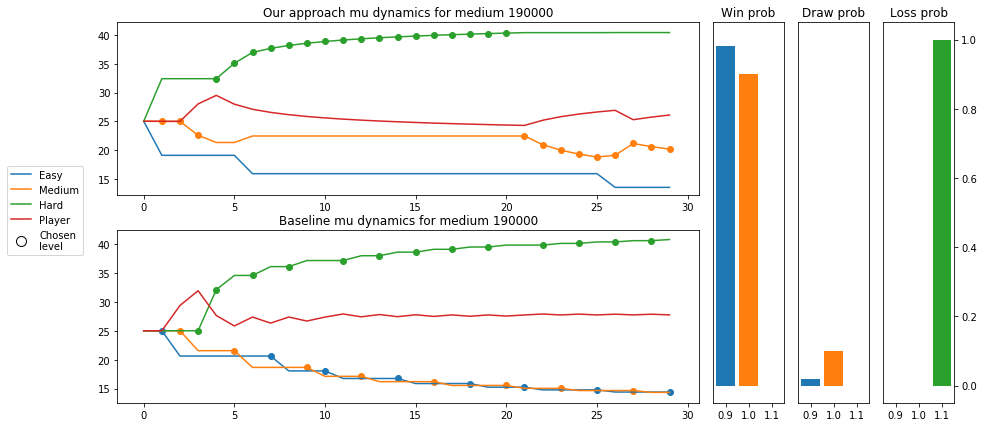

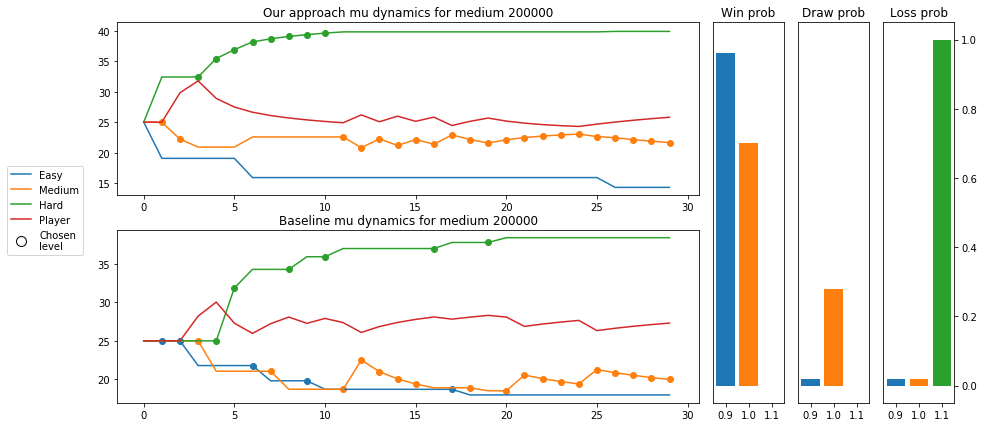

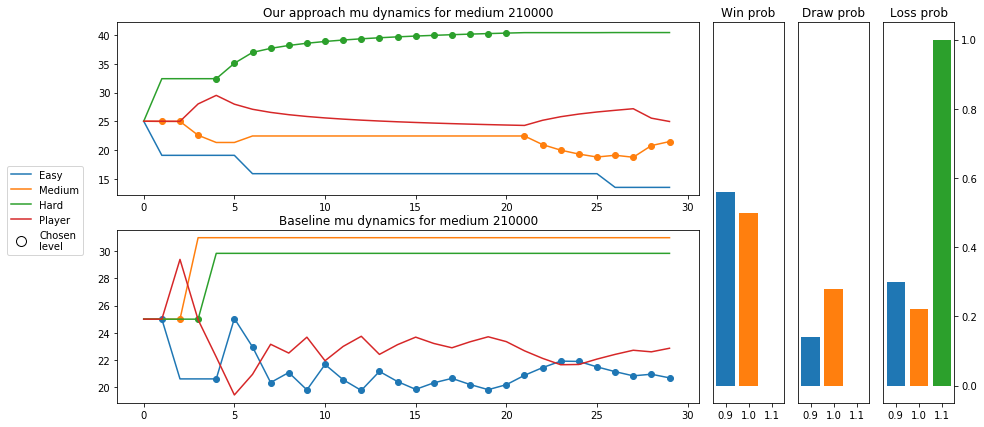

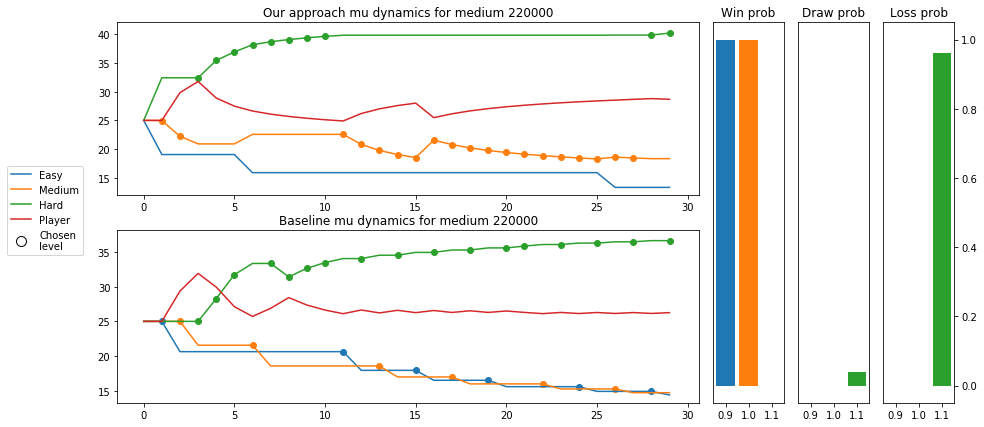

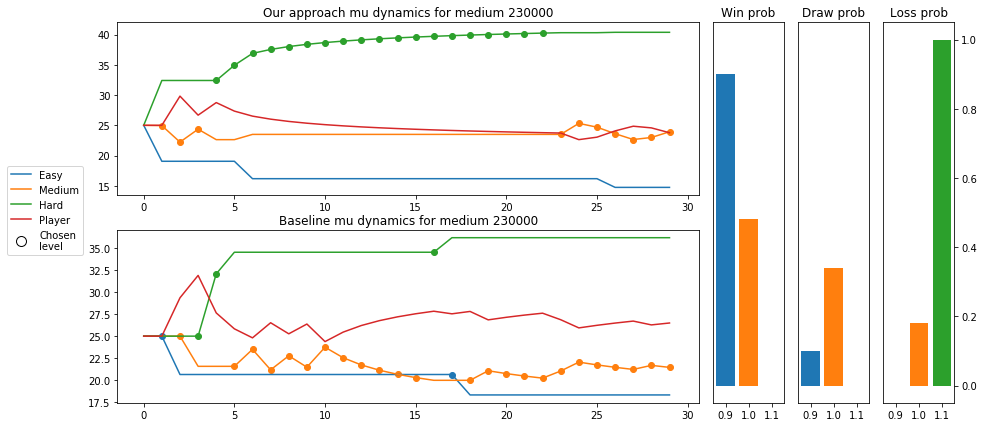

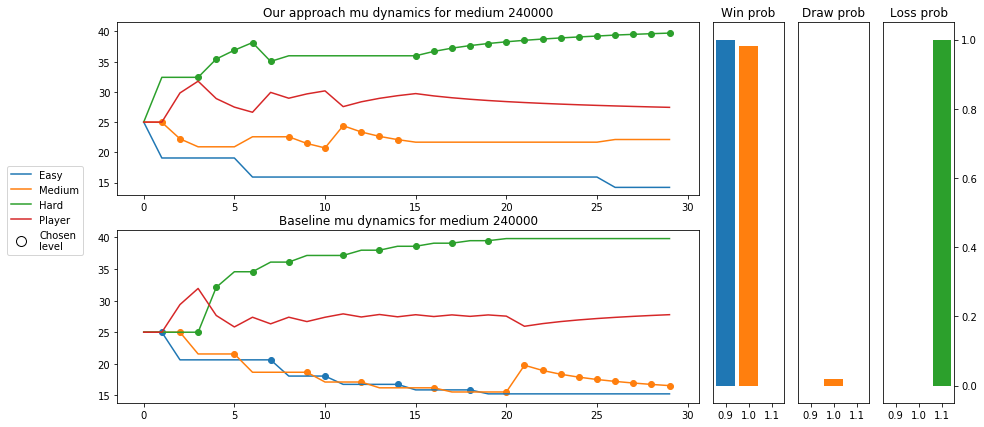

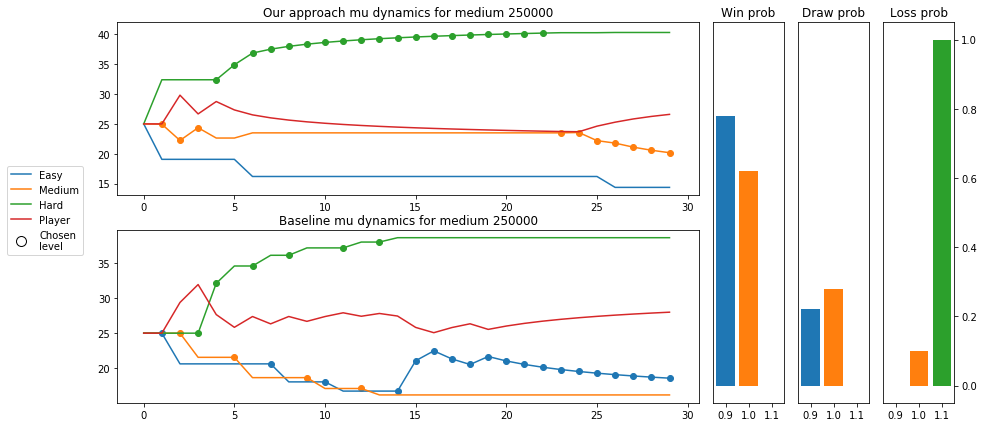

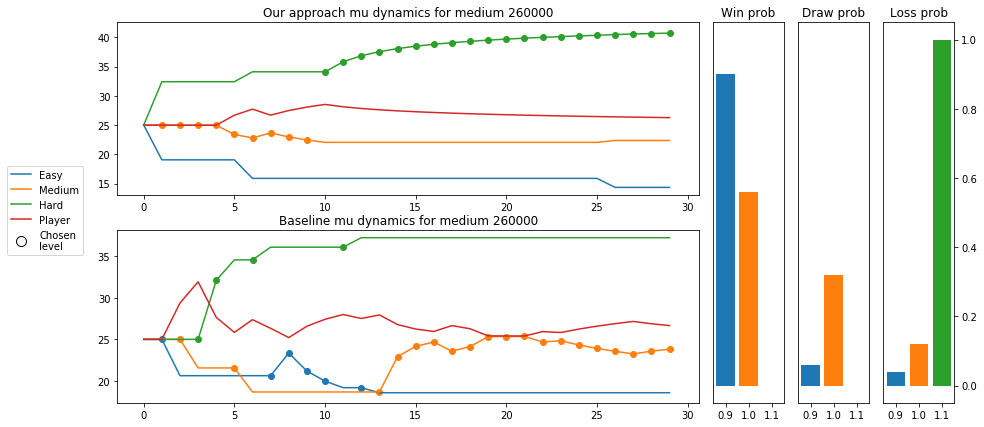

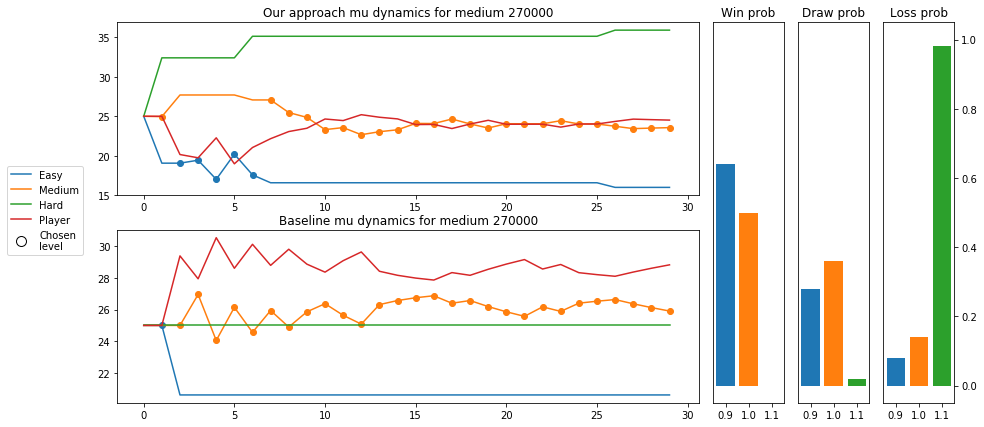

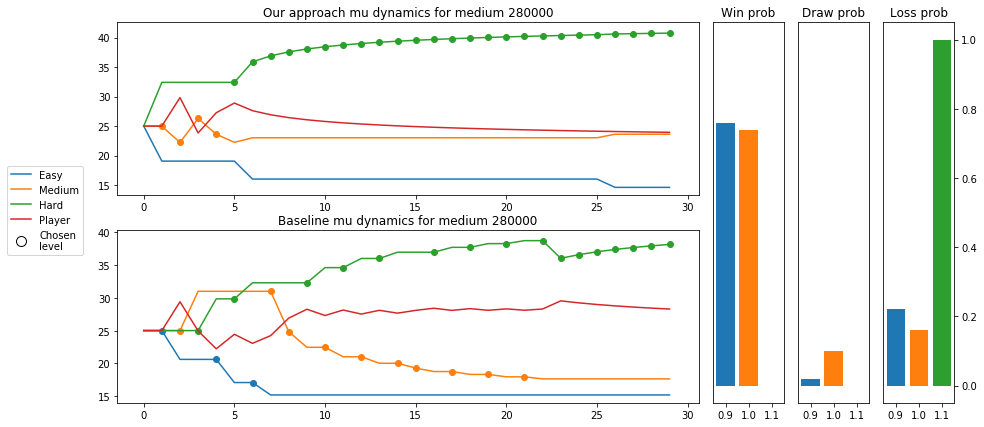

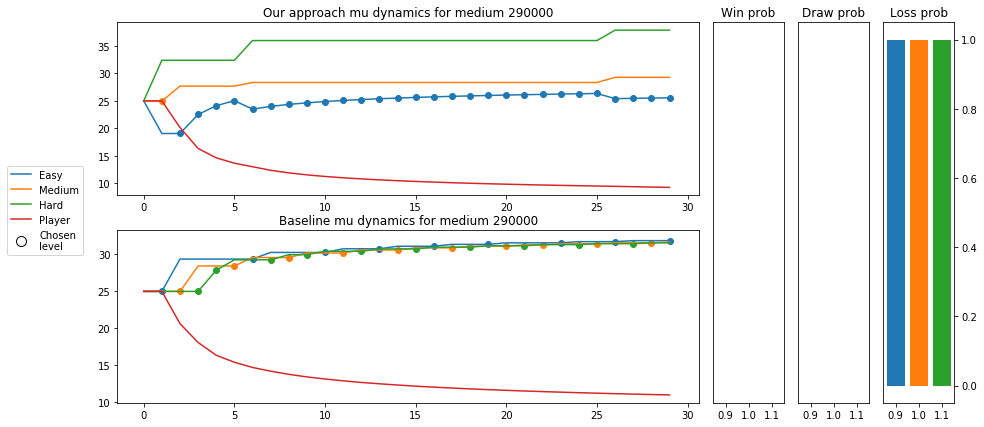

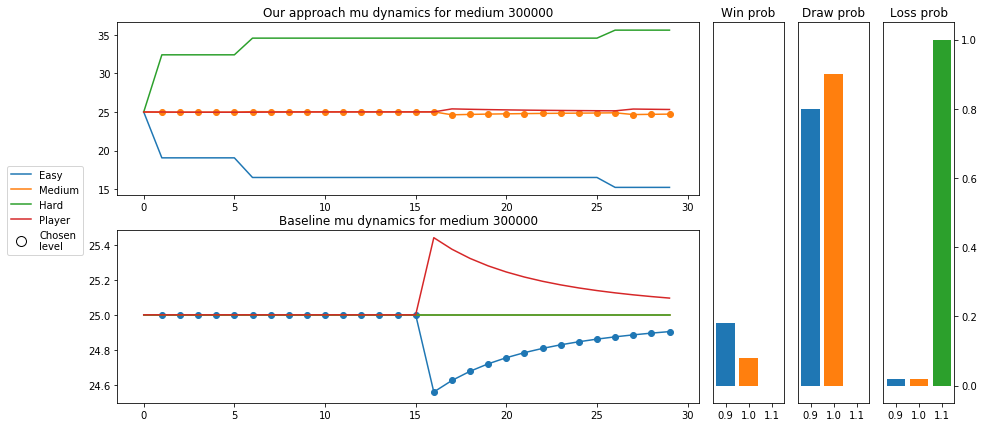

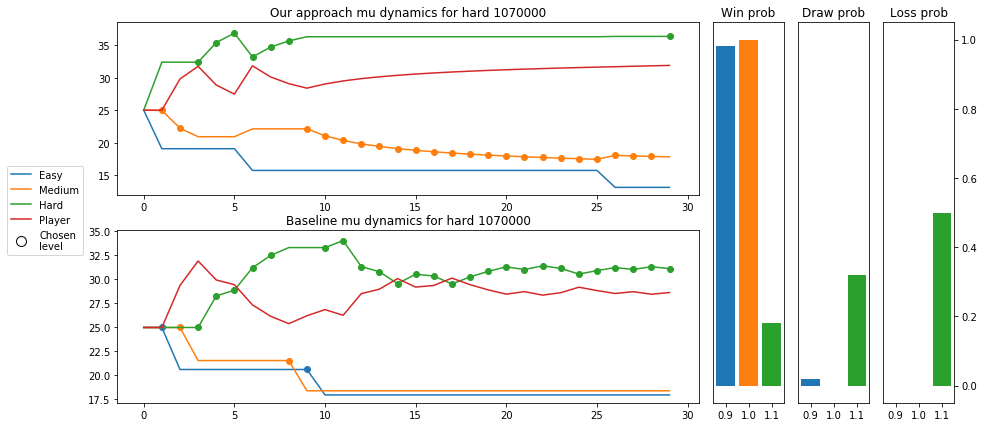

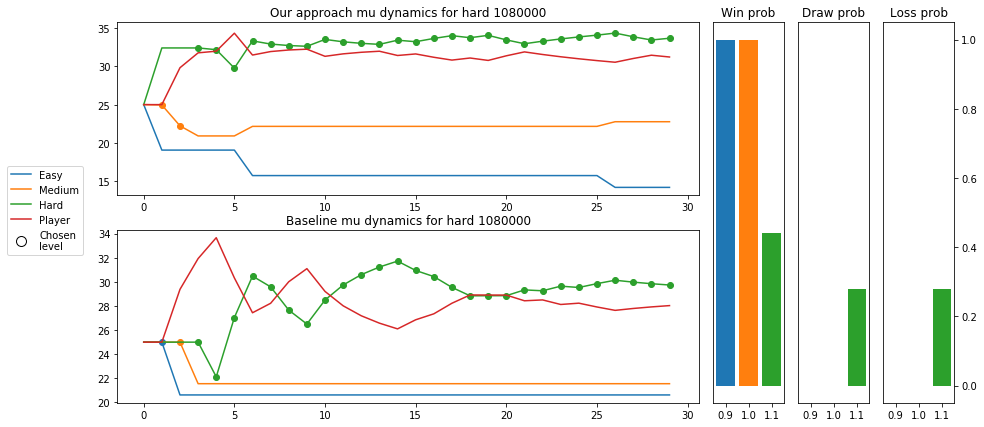

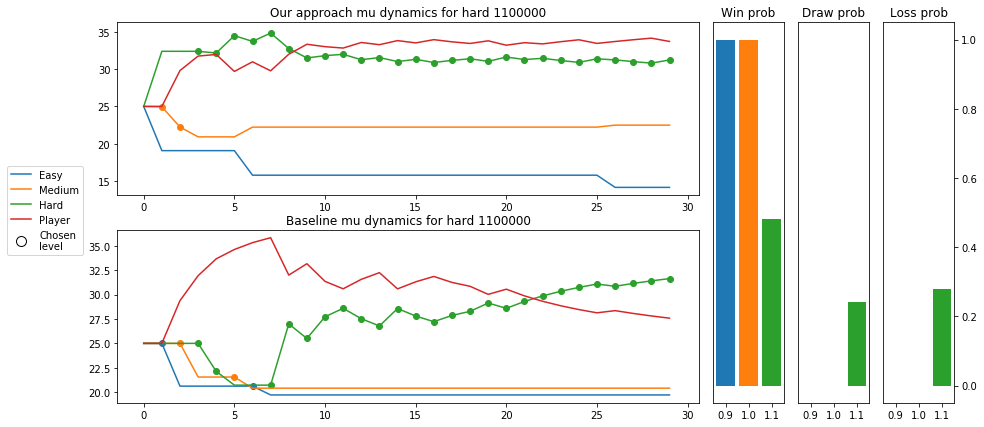

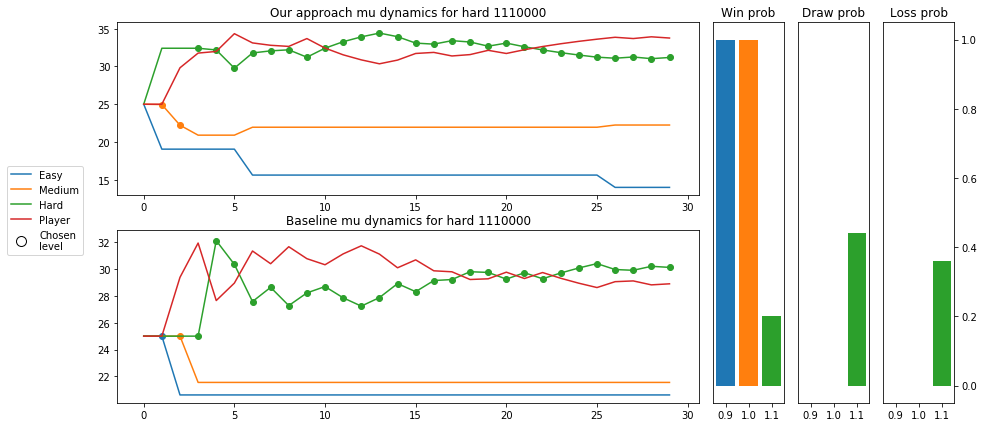

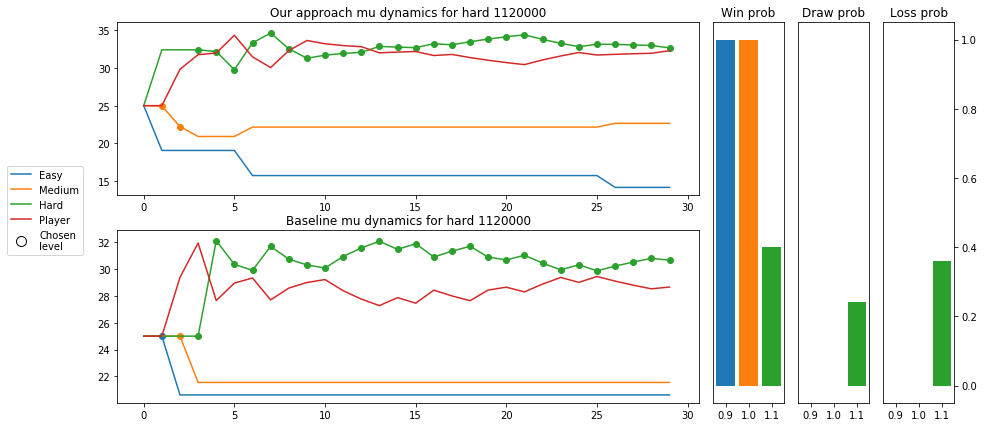

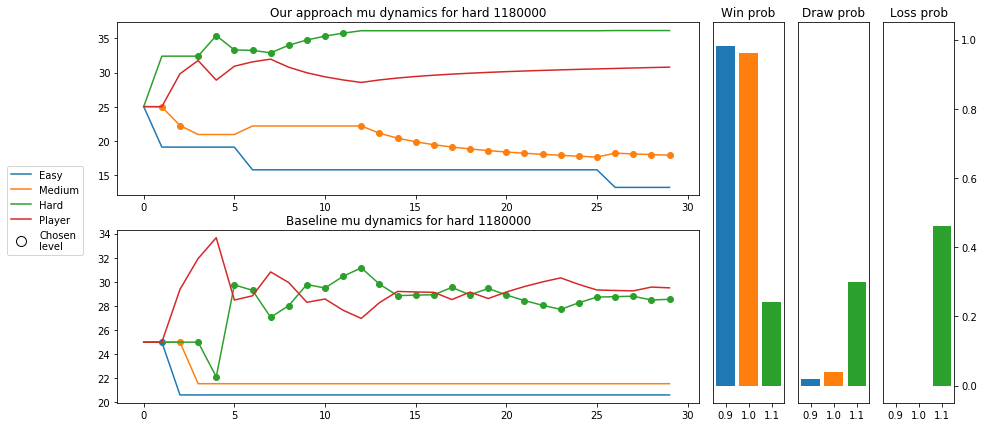

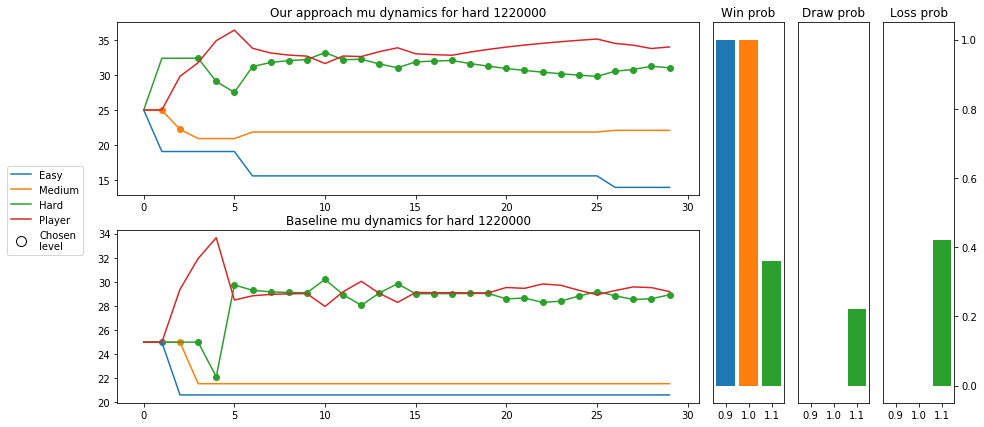

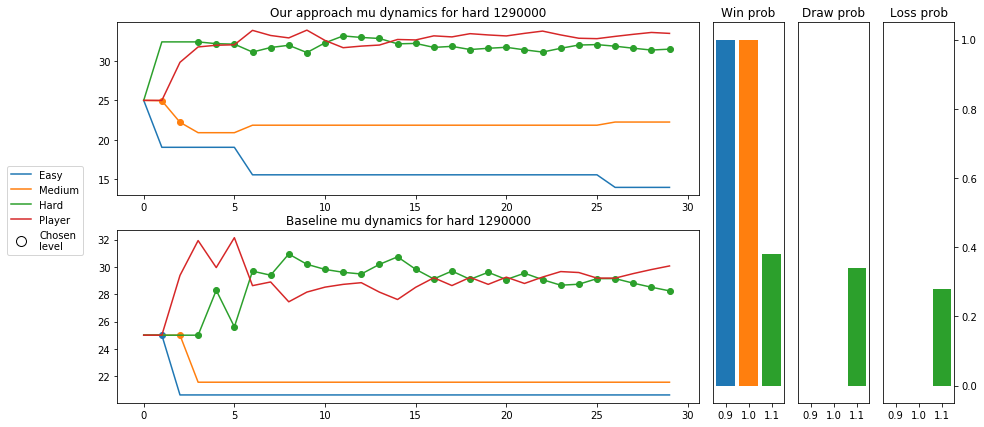

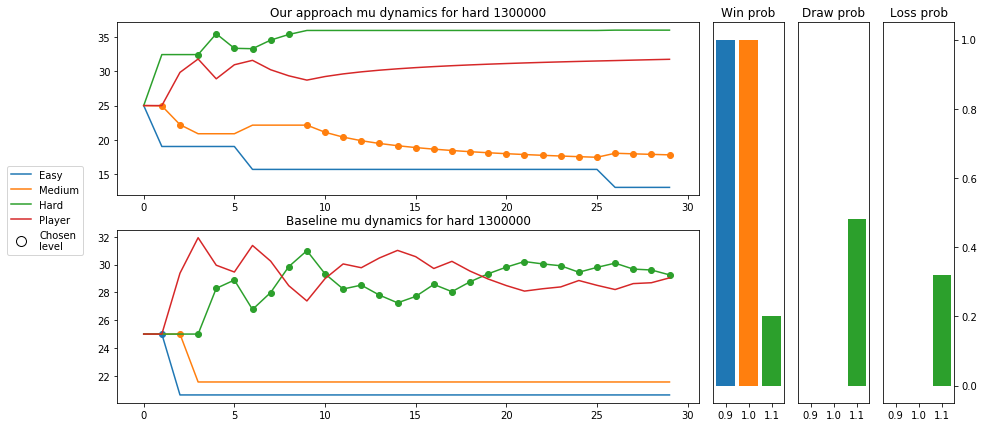

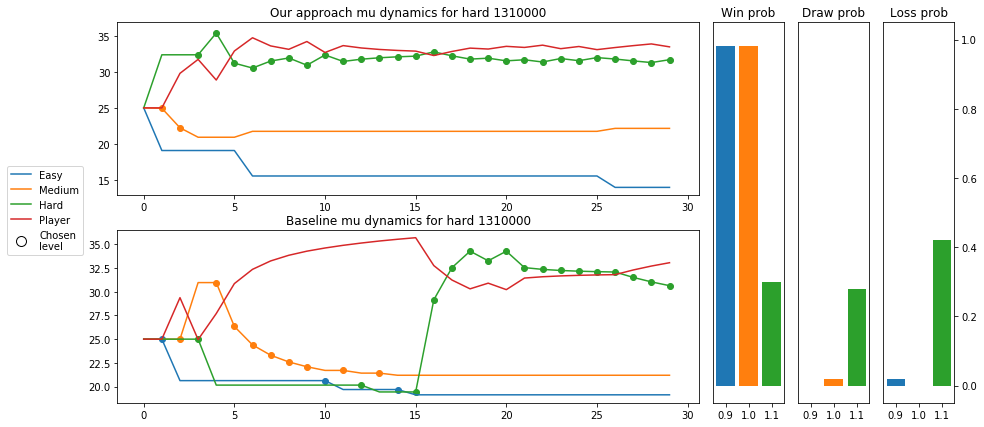

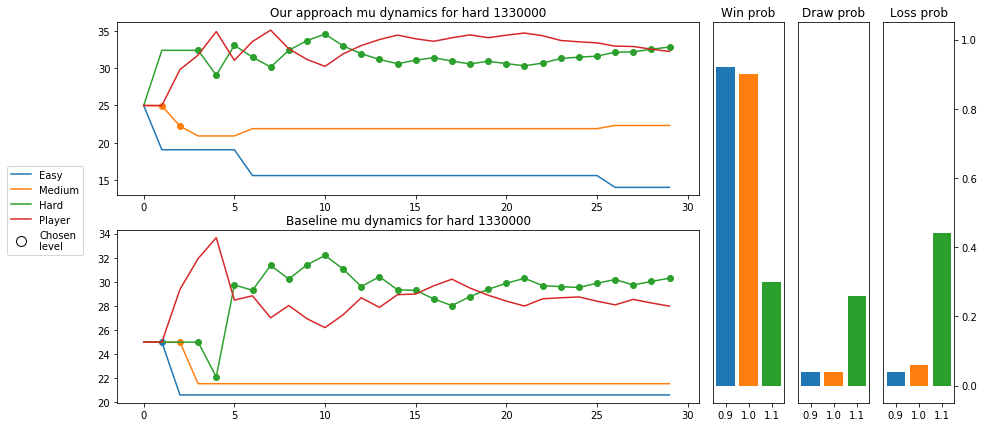

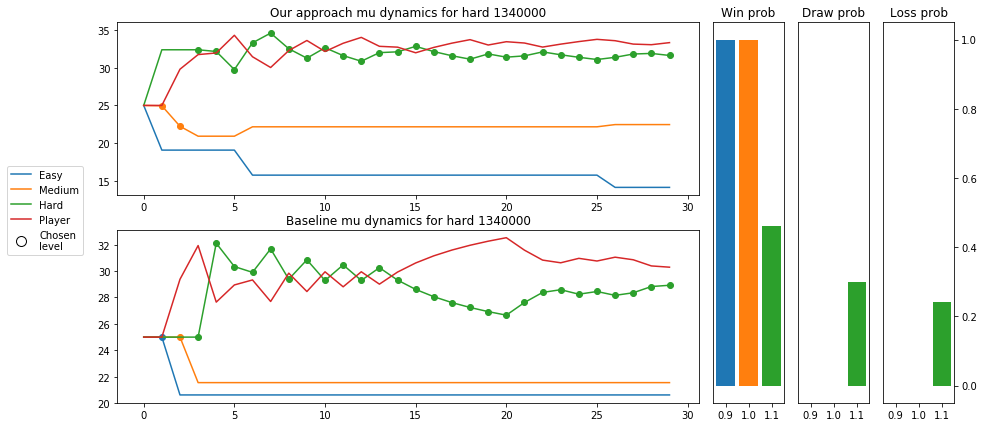

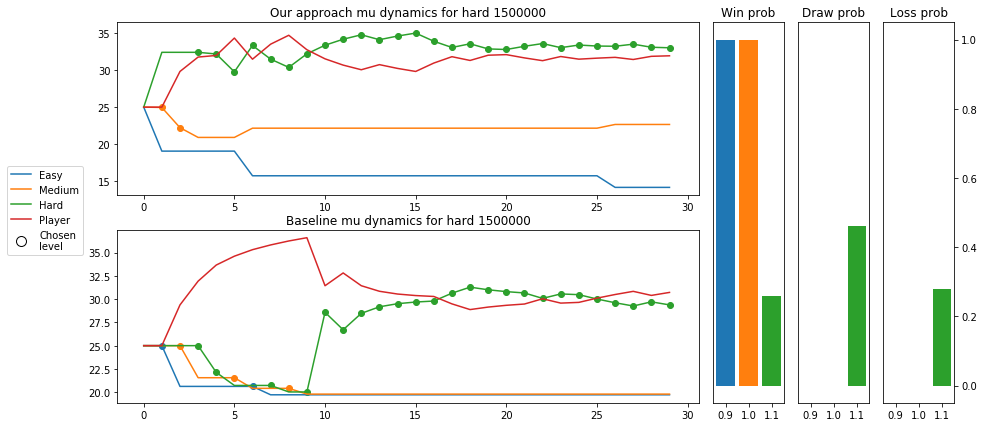

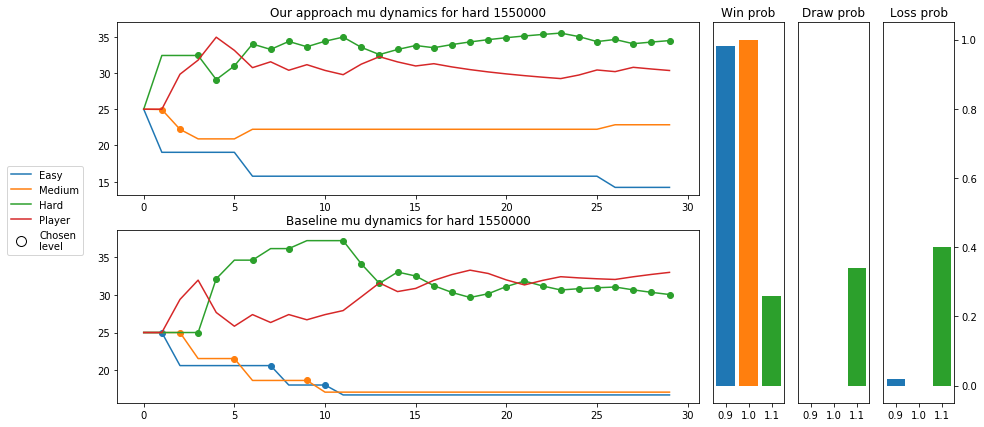

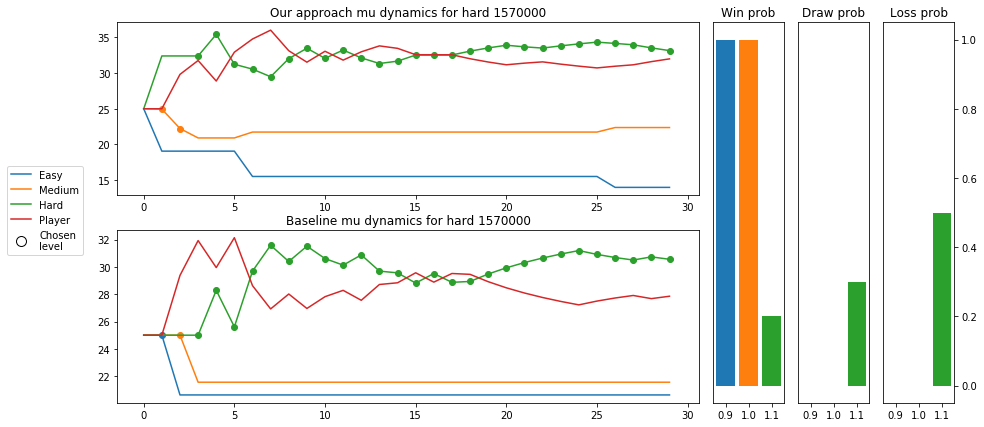

In [2]:
keys = get_all_models_keys()
#keys = keys[:1]
for k in keys:
    pl, opp = reconstruct_mu_dynamics(k[0], k[1])
    pl_base, opp_base = reconstruct_mu_dynamics(k[0], k[1], baseline=True)
    probs = reconstruct_probs(k[0], k[1])
    title = 'mu dynamics for {} {}'.format(k[0], k[1])
    plot_(title, pl, opp, pl_base, opp_base, probs, save_plots=False)

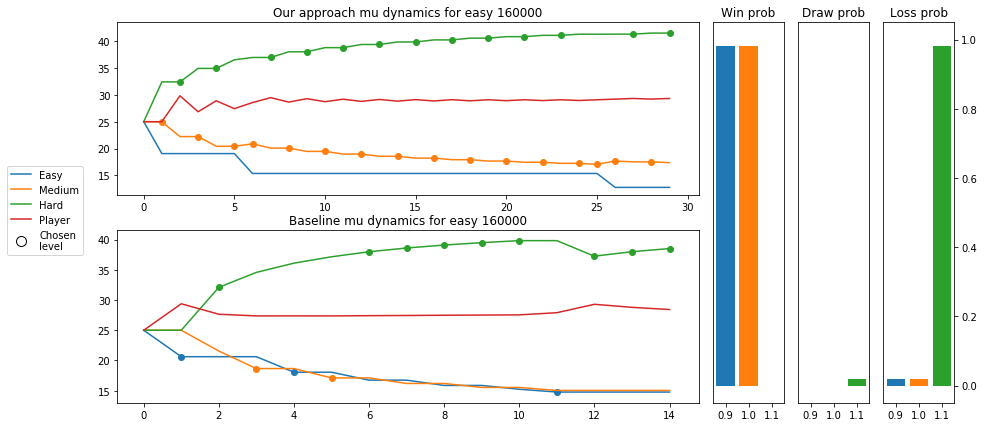

In [52]:
pl, opp = reconstruct_mu_dynamics('easy', 160000, baseline=False)
pl_base, opp_base = reconstruct_mu_dynamics('easy', 160000, baseline=True)

opp_base_res = []
pl_base_res = []
for i in range(len(pl_base)):
    tmp = []
    
    for j in range(len(pl_base[i])):
        if(j%2==0):
            tmp.append(pl_base[i][j])
    pl_base_res.append(tmp)

for i in range(len(opp_base)):
    if i%2==0:
        opp_base_res.append(opp_base[i])
probs = reconstruct_probs('easy', 160000)
title = 'mu dynamics for {} {}'.format('easy', 160000)
plot_(title, pl, opp, pl_base_res, opp_base_res, probs, save_plots=True)

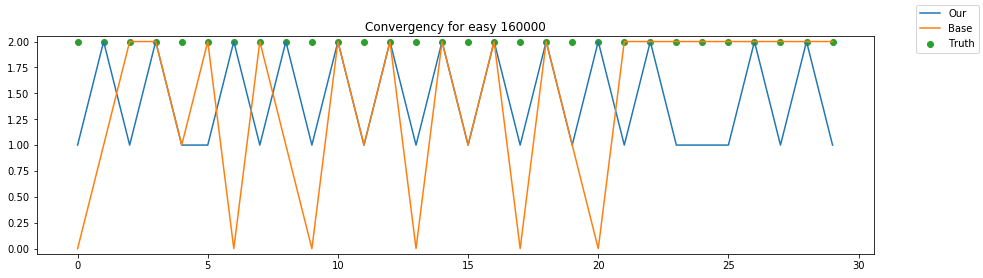

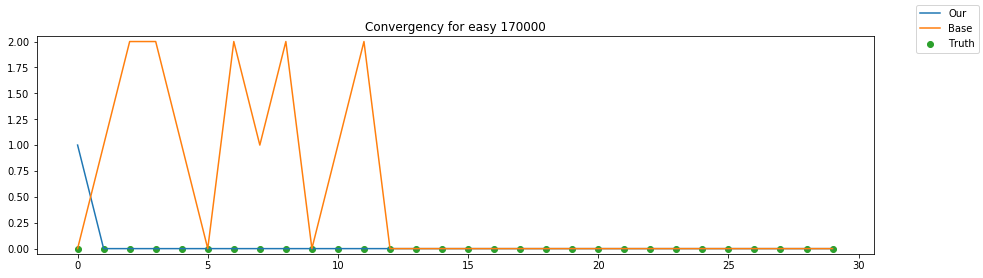

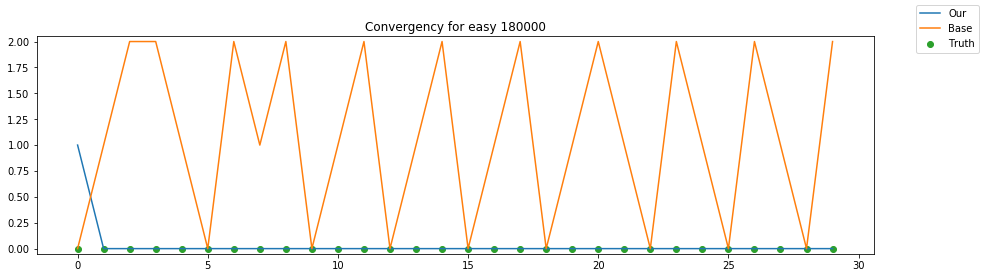

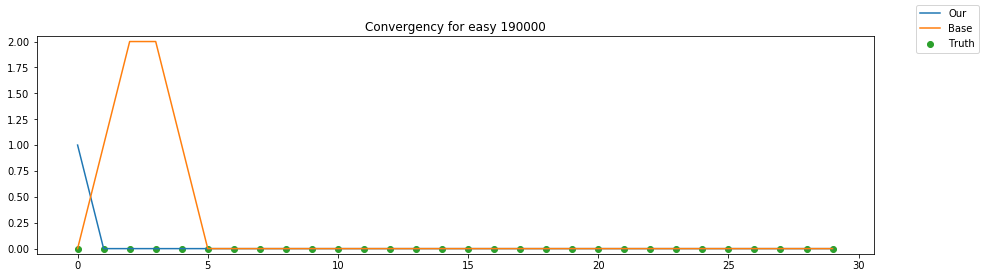

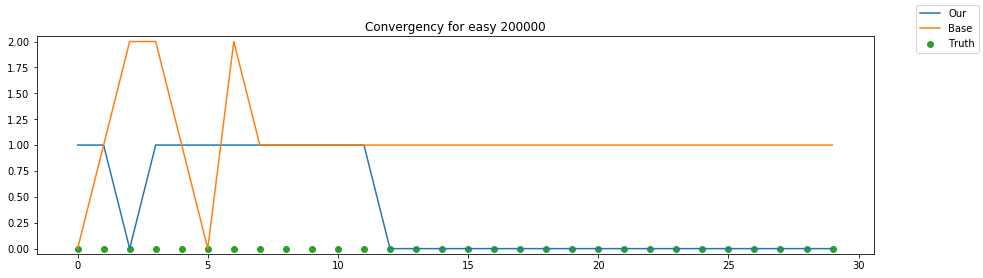

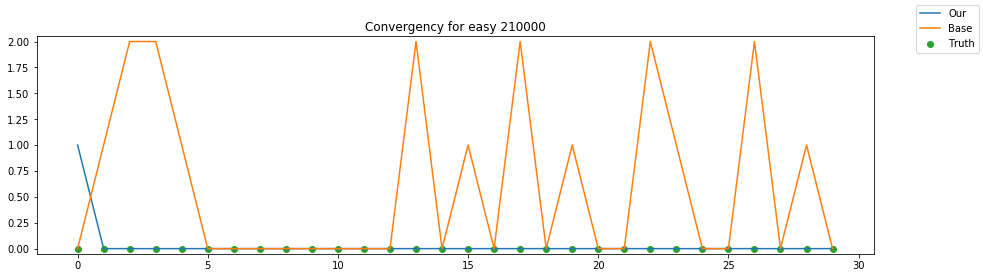

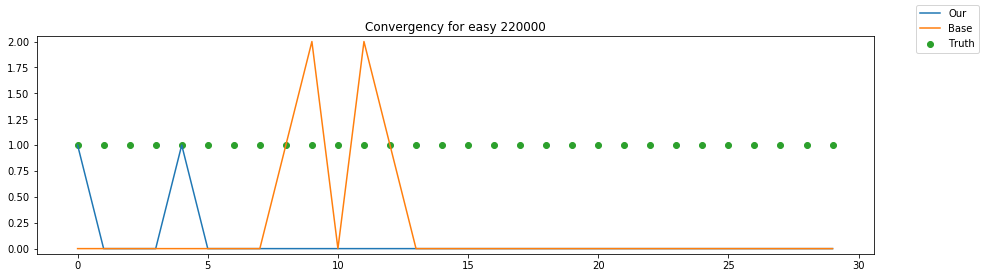

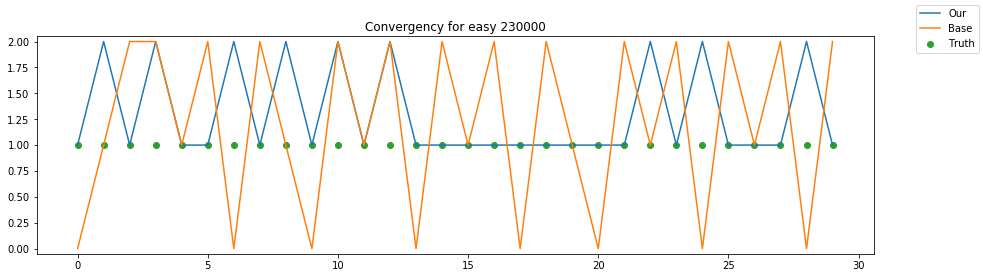

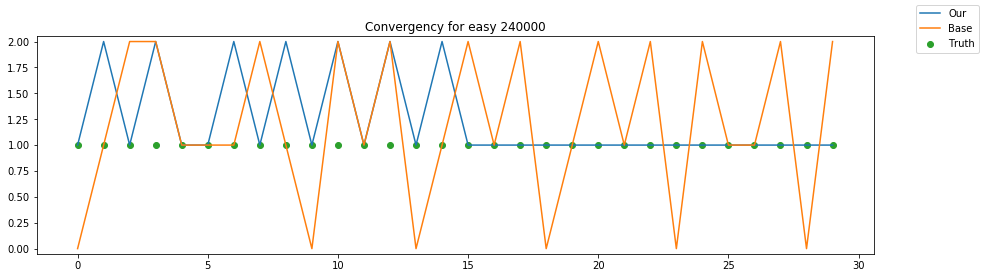

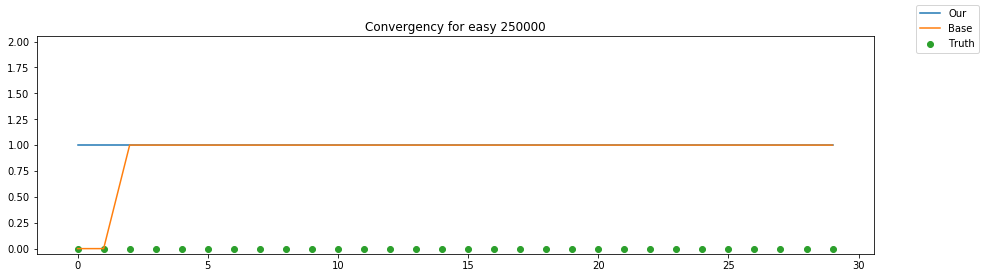

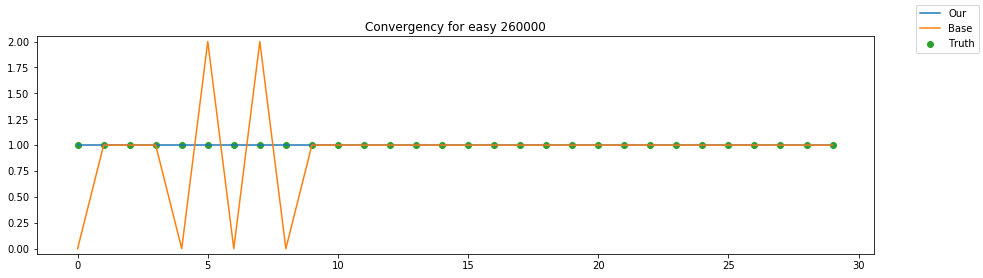

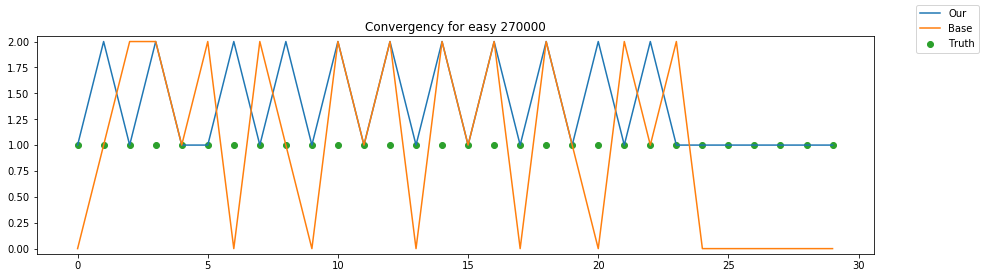

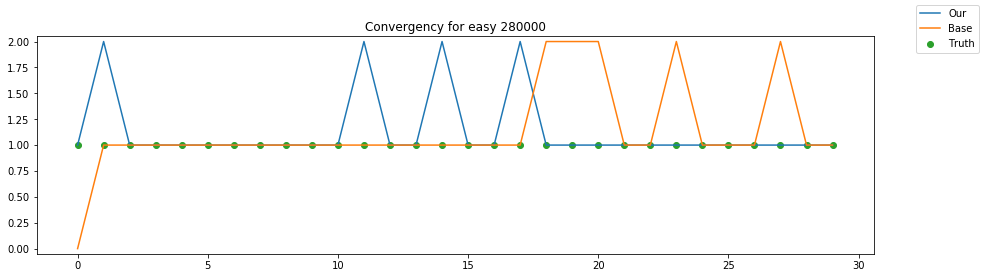

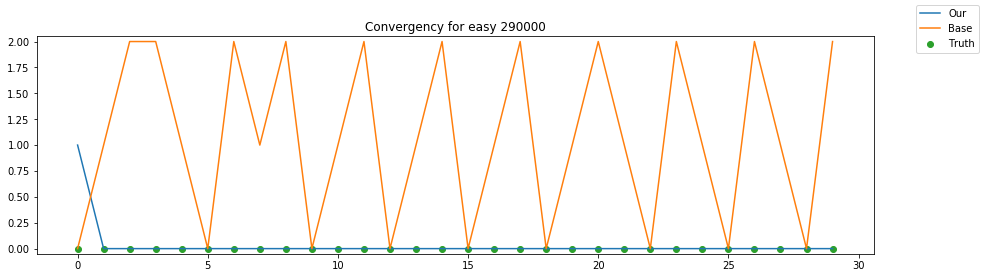

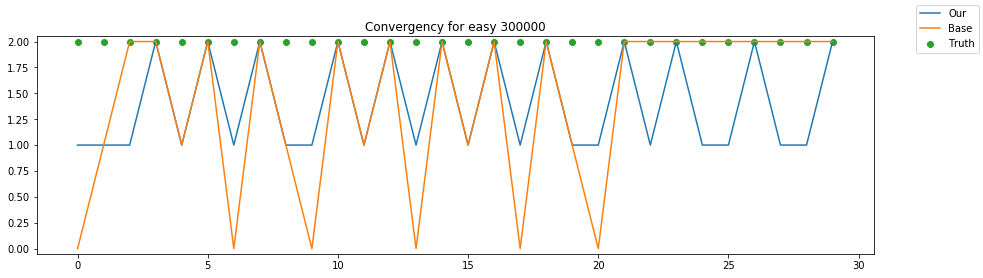

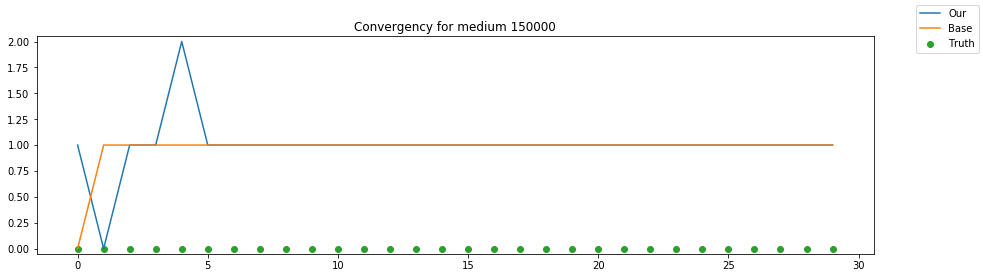

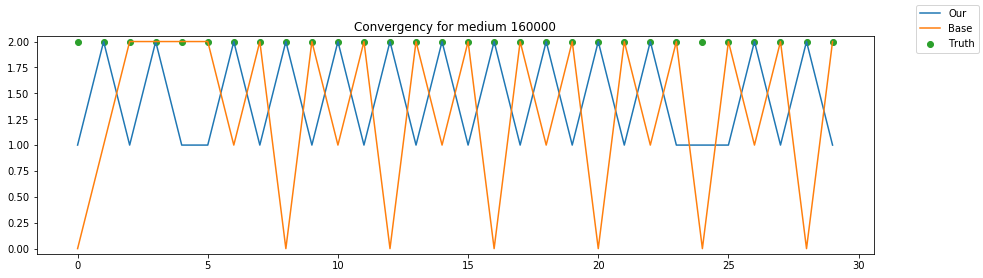

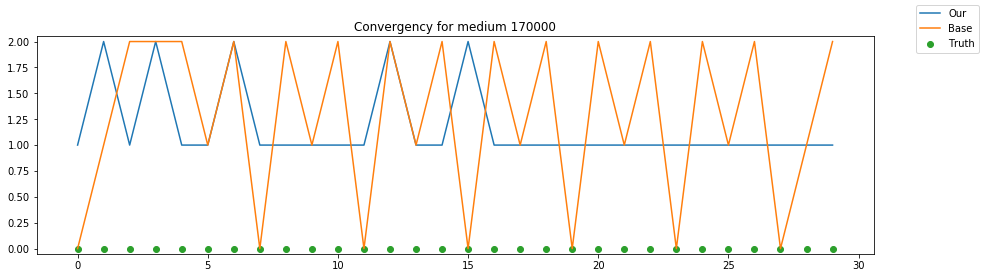

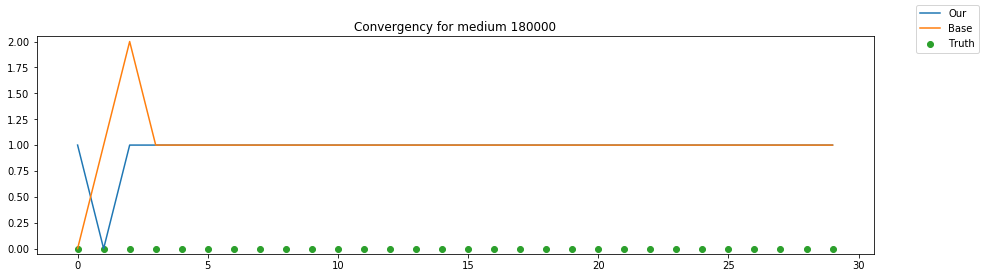

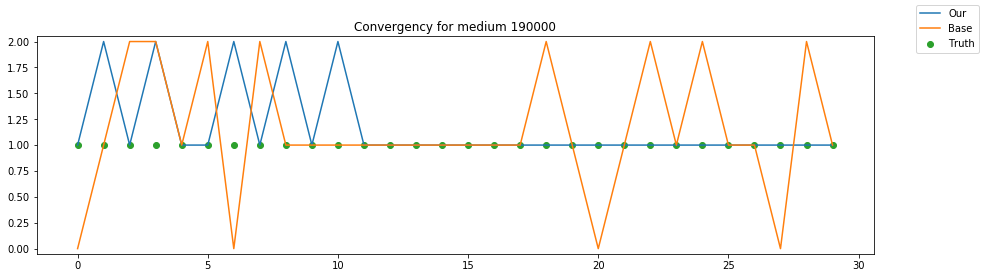

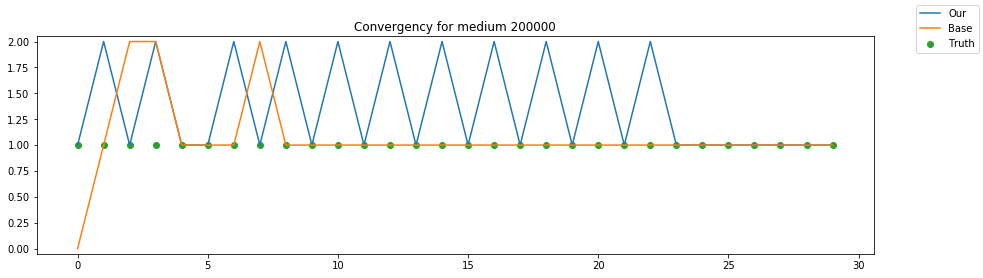

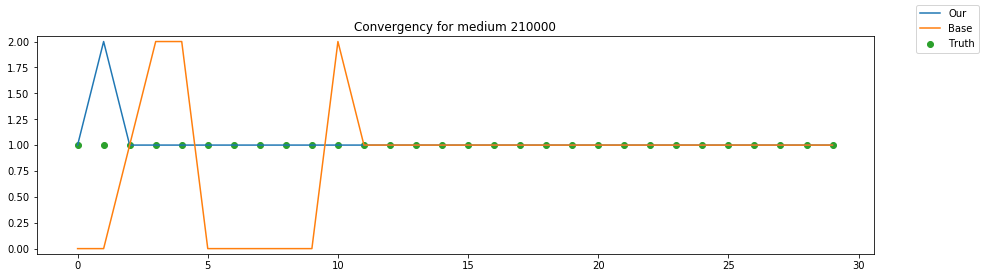

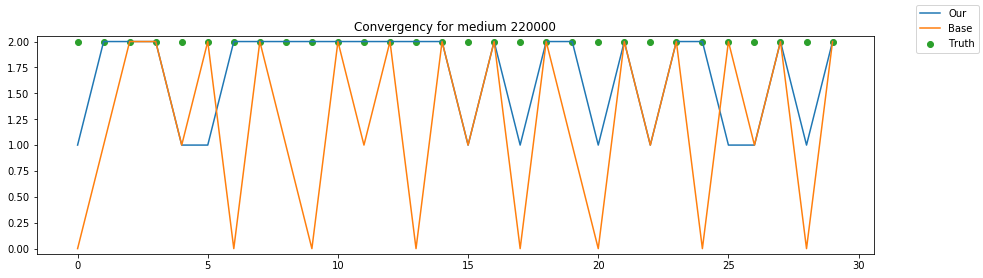

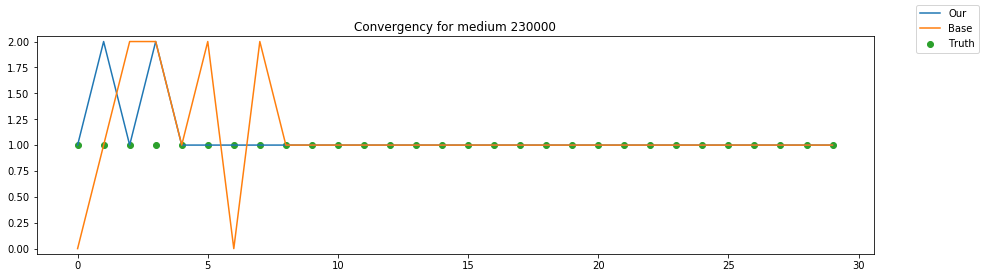

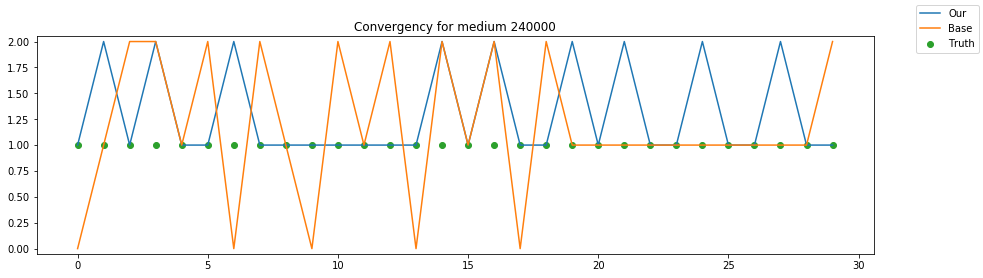

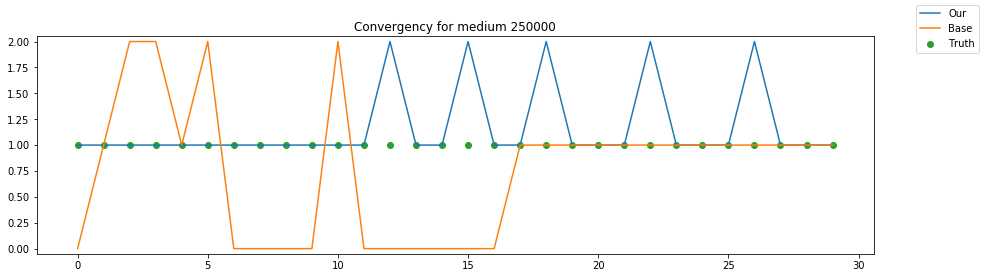

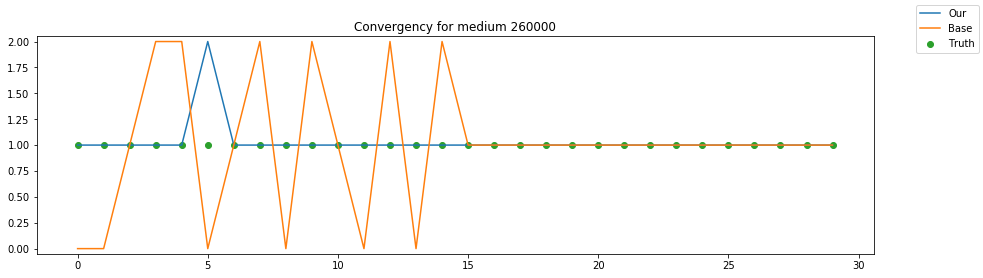

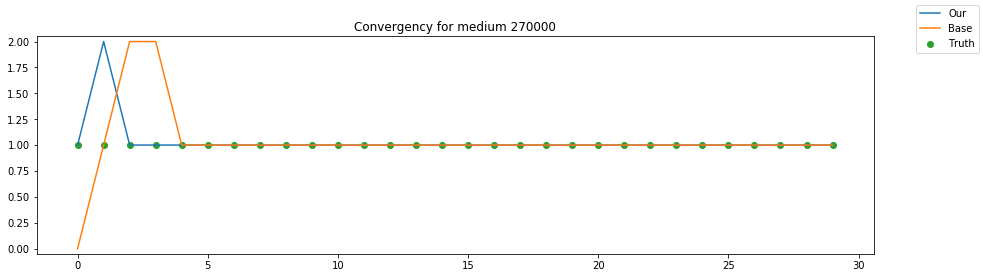

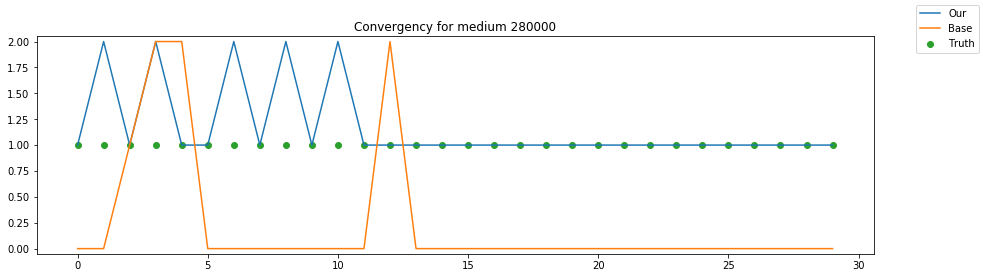

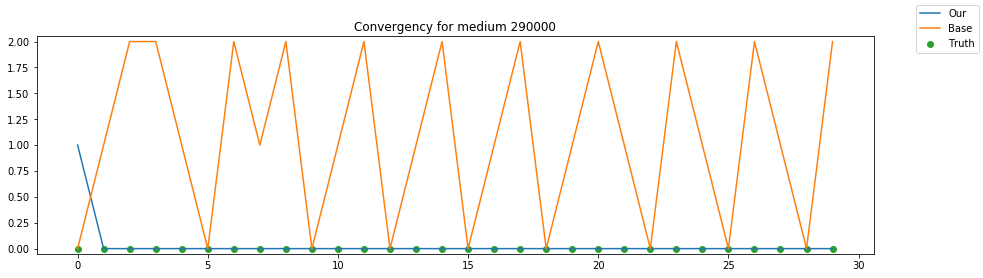

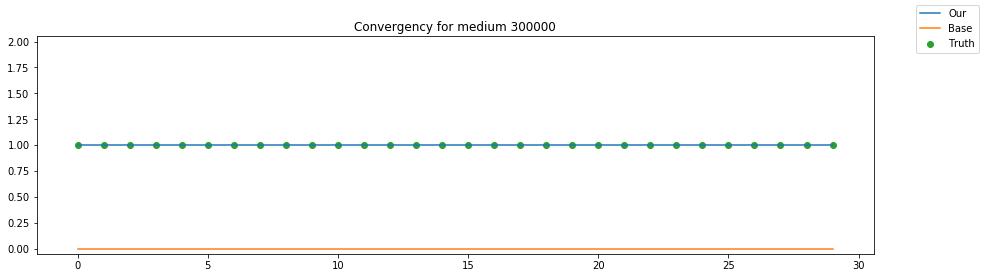

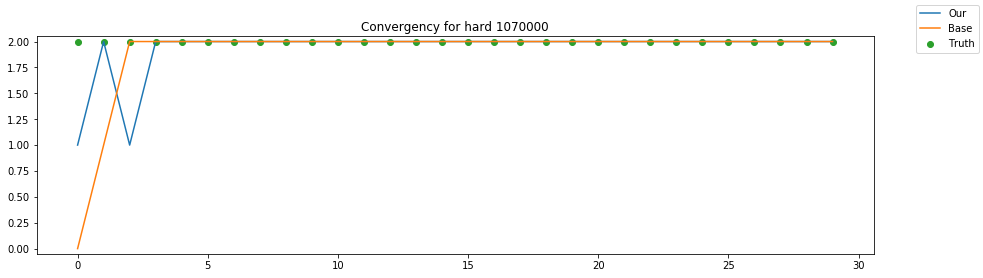

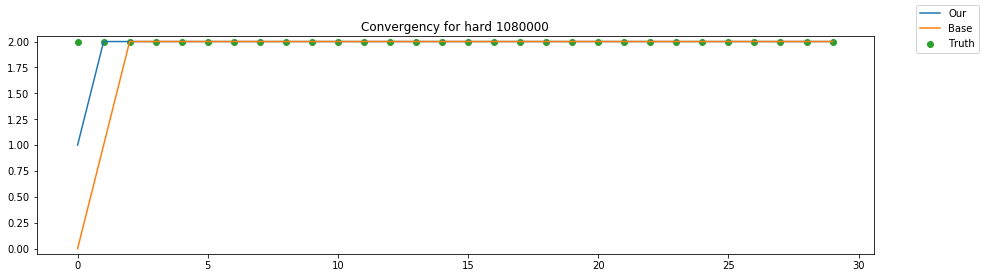

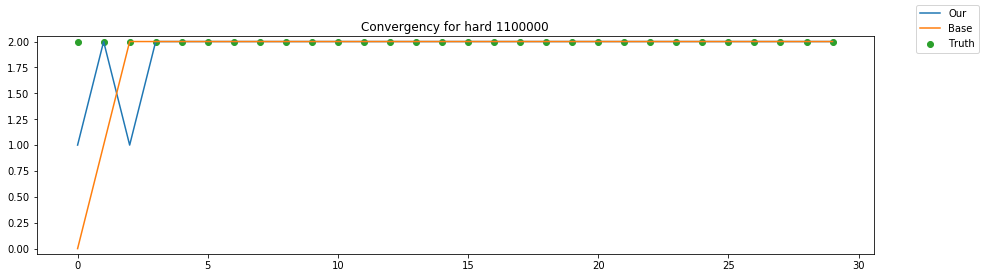

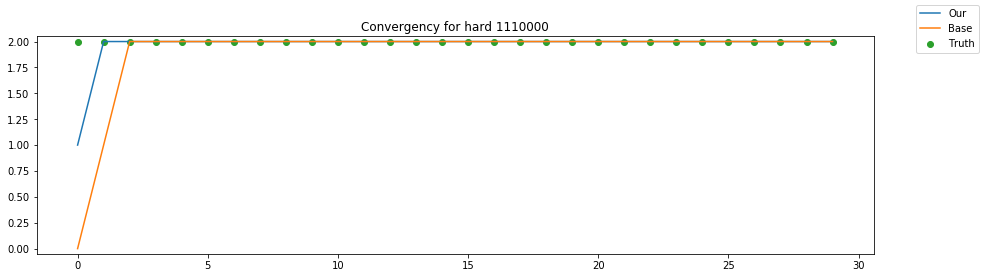

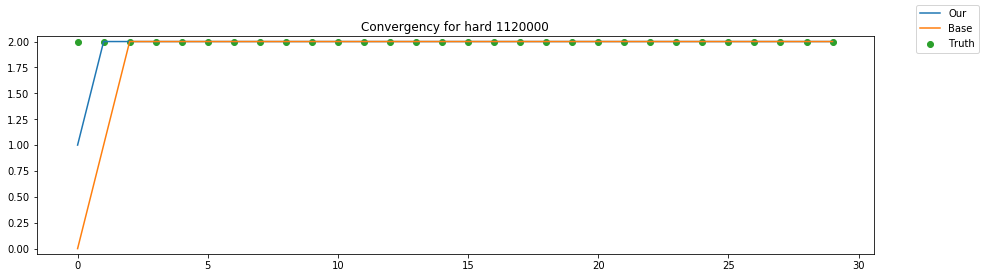

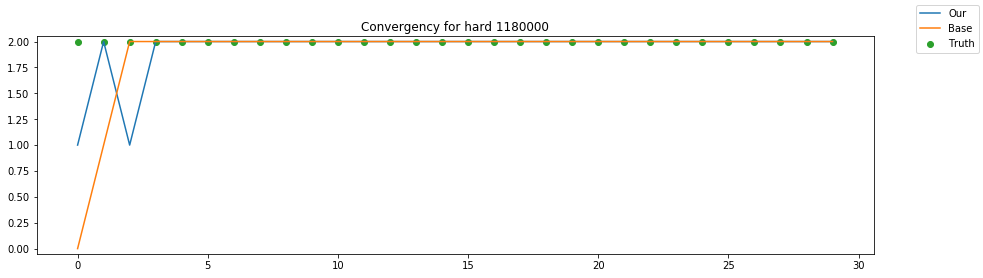

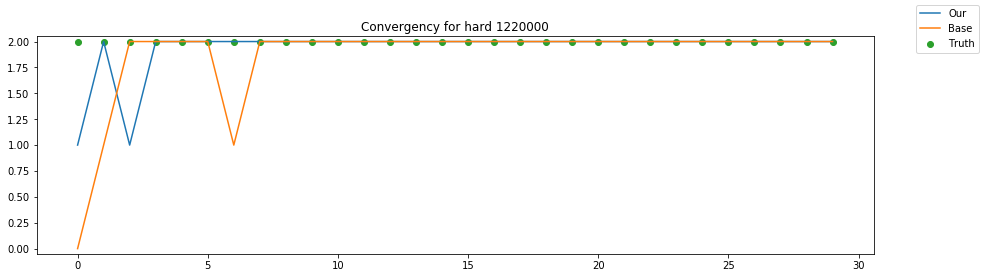

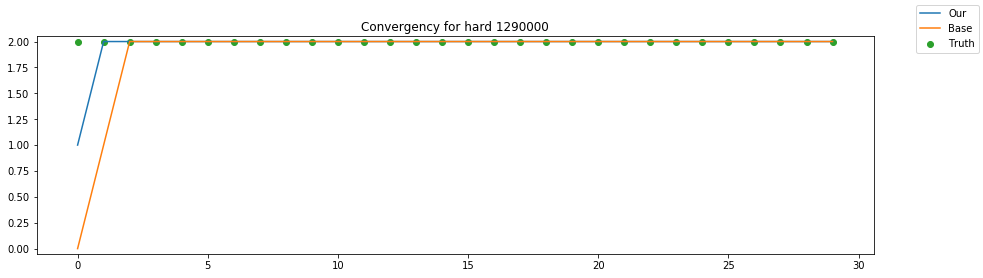

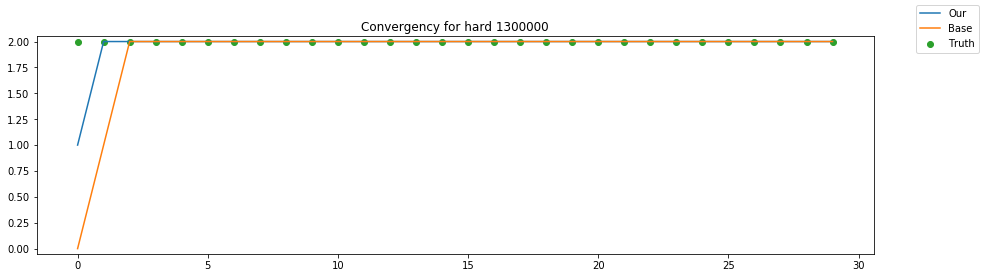

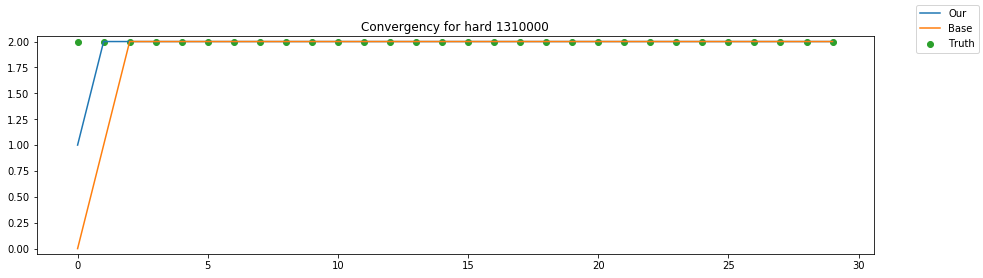

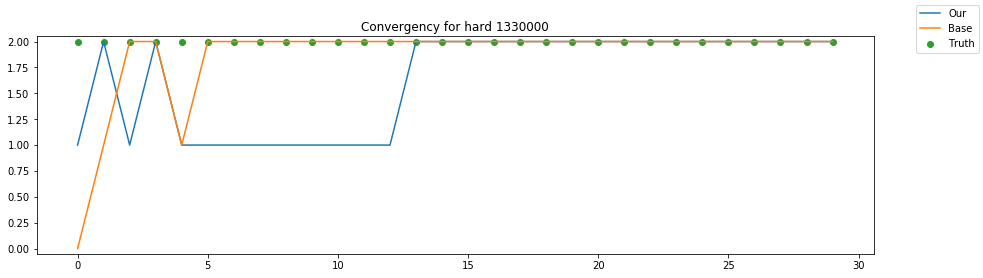

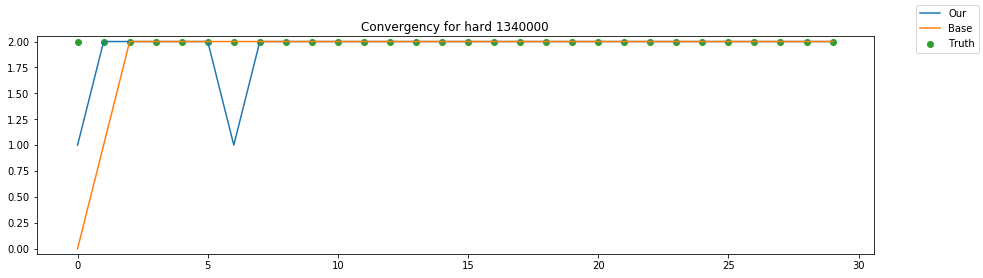

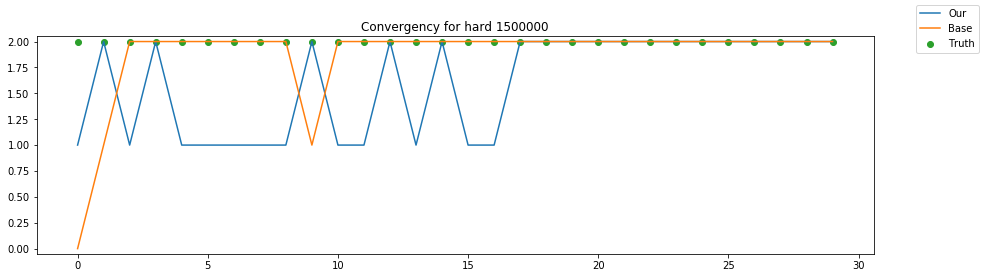

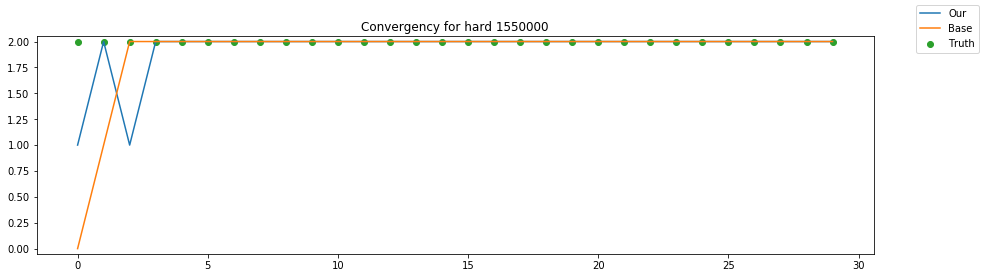

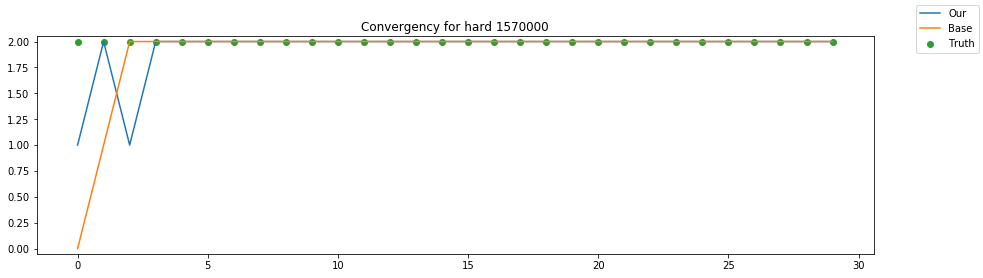

In [91]:
keys = get_all_models_keys()
#keys = keys[:1]
for k in keys:
    pl, opp = reconstruct_mu_dynamics(k[0], k[1])
    pl_base, opp_base = reconstruct_mu_dynamics(k[0], k[1], baseline=True)
    probs = reconstruct_probs(k[0], k[1])
    title = 'Convergency for {} {}'.format(k[0], k[1])
    #plot_(title, pl, opp, pl_base, opp_base, probs, save_plots=True)
    plot_decision(title, opp, opp_base, k[2], save_plots=False)

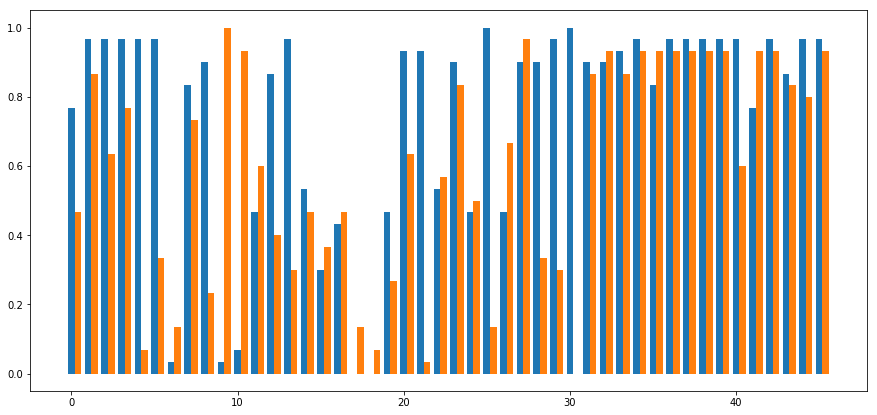

In [5]:
def get_truth_rate(opps, truth):
    count = 0.0
    for o in opps:
        if o == truth:
            count+=1
    #print(count)
    return count / len(opps)

keys = get_all_models_keys()
#keys = keys[:1]
rates = []
rates_base = []
for k in keys:
    pl, opp = reconstruct_mu_dynamics(k[0], k[1])
    pl_base, opp_base = reconstruct_mu_dynamics(k[0], k[1], baseline=True)
    probs = reconstruct_probs(k[0], k[1])
    title = 'A for {} {}'.format(k[0], k[1])
    rates.append(get_truth_rate(opp, k[2]))
    rates_base.append(get_truth_rate(opp_base, k[2]))
    #plot_(title, pl, opp, pl_base, opp_base, probs, save_plots=True)
plot_truth_rate(title, rates, rates_base, save_plots=False, width=0.4)

In [7]:
for t in np.linspace(0, 1, 11, endpoint=True):
    print(t)
    good_ones = [x>=t for x in rates]
    n = sum(good_ones)
    #print(n)
    print(float(n/len(good_ones)))
    print()

0.0
1.0

0.1
0.9130434782608695

0.2
0.8478260869565217

0.30000000000000004
0.7608695652173914

0.4
0.6956521739130435

0.5
0.6086956521739131

0.6000000000000001
0.5217391304347826

0.7000000000000001
0.45652173913043476

0.8
0.41304347826086957

0.9
0.2826086956521739

1.0
0.021739130434782608

